# Case Study - Lending Club 

## Section 1 - Data Understanding

### 1.1 Goal

The goal of the case study is to analyze which of the future applications could be defaulters, helping in reducing losses. Making use of EDA, we are to come up with parameters which would help uncover the parameters which could help indentify a defaulter

### 1.2 Understanding the dataset

- The primary attribute is the Loan Status which is of the major interest. Loan status has 3 values as per the dataset:
    - **Fully Paid** : As the name suggests these are loans which have been paid completely
    - **Charged Off** : Defaulted loans
    - **Current** : These records are the ones which are currently being paid. 
    
    
- The columns that are of significance which would help devise the algorithm:
  * **Annual Income (annual_inc)** 
  * **Home Ownership (home_ownership)**
  * **Employment Length (emp_length)**
  * **Debt to Income (dti)**
  * **State (addr_state)**
  * **Loan Amount (loan_amt)**
  * **Grade (grade)**
  * **Term (term)**
  * **Loan Date (issue_d)**
  * **Purpose of Loan (purpose)**
  * **Verification Status (verification_status)**
  * **Interest Rate (int_rate)**
  * **Installment (installment)**
  * **Public Records (public_rec)**
  * **Public Records Bankruptcy (public_rec_bankruptcy)**

### 1.3 Row analysis

- Records with loan status Current have zero contribution to analysis since the loans are still in progress. These records will be dropped.
- Duplicate records in the dataset will be removed

### 1.4 Column analysis
- Columns with only null values will be dropped
- Columns with only one unique value will be dropped
- Columns with more that 75% of null values will be dropped
- Certain identifier columns - id, member_id have no contribution to the analysis. They will be dropped.
- Columns - emp_title, desc, title, url are going be to dropped.

**Column clean up**
- Strip months from the term, thereby converting it to integer format
- Convert int_rate from percentange to float
- All currency columns will be rounded off to 2 decimal places, as currency values are limited to cents.
- Similar values for home_ownership like `NONE` and `OTHER` is standardized as `OTHER`.
- Similar values for verification_status like `Source Verified` and `Verified` is standardized as `Verified` 

**New columns**
- `loan_status_numeric` is added to represent loan_status as a number. Fully Paid -> 0, Charged Off -> 1
- `emp_length_numeric` is added to represent emp_length as a comparable number with < 1 year = 0, 10+ years = 10
- `issue_y` represents the year extracted from `issue_d`.
- `issue_m` represents the month extracted from `issue_d`.
- `issue_q` has been added for binning the data quarter-wise.
- `loan_paid` has been added for simple mapping of Yes (Fully Paid) or No (Charged Off).
- `dti_bucket` has been added for binning DTI values from 8 (Very Low) to 20 (Very High).
- `loan_amnt_bucket` has been added for binning loan amount values.
- `funded_amnt_bucket` has been added for binning funded amount values.
- `annual_inc_bucket` has been added for binning annual income values.
- `int_rate_bucket` has been added for binning interest rate values.

### 1.5. Handling Outliers

- Outlier evaluation is performed on the columns: `loan_amnt`, `funded_amnt`, `funded_amnt_inv`, `int_rate`, `installment`, `annual_inc`, `dti`.

## Section 2 - Data cleaning and manipulation

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [104]:
df = pd.read_csv('loan.csv')
df.shape

(39717, 111)

### 2.1 Remove redundant columns (Columns which aren't useful, are empty and have only one unique value)

In [105]:
drop_columns = [
 'collection_recovery_fee',
 'delinq_2yrs',
 'desc',
 'earliest_cr_line',
 'emp_title',
 'id',
 'inq_last_6mths',
 'last_credit_pull_d',
 'last_pymnt_amnt',
 'last_pymnt_d',
 'member_id',
 'open_acc',
 'out_prncp',
 'out_prncp_inv',
 'pub_rec',
 'recoveries',
 'revol_bal',
 'revol_util',
 'title',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'total_rec_prncp',
 'url',
 'zip_code'
]

df.drop(columns=drop_columns, inplace=True)
df.dropna(axis = 1, how = 'all', inplace = True)
df.drop(columns = df.columns[df.nunique() == 1], inplace=True)
df.shape

(39717, 21)

### 2.2 Drop records where loan_status is Current

In [106]:
df = df[df['loan_status'].str.lower() != "current"]
df.shape

(38577, 21)

### 2.3 Drop columns where missing data is more than 65%

In [107]:
for col in df.columns:
    missing = round(df[col].isna().sum() / df.shape[0], 2)
    if missing >= 0.65:
        df.drop(col, axis = 1, inplace = True)
        
df.shape

(38577, 18)

### 2.4 Common functions

In [108]:
def plot_bar_graph(dataframe, x_column, y_column=None, hue_column=None, title=None, xlabel=None, ylabel=None, figsize=(10, 6), x_tick_rotation=90, freq_rotation=0, filter_column=None, filter_value=None):
    """
    Create a Seaborn bar plot for a specified column in a DataFrame.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        x_column (str): The name of the column to be plotted on the x-axis.
        y_column (str, optional): The name of the column to be plotted on the y-axis. Default is None.
        hue_column (str, optional): The name of the column to use for color differentiation. Default is None.
        title (str, optional): The title of the plot. Default is None.
        xlabel (str, optional): Label for the x-axis. Default is None.
        ylabel (str, optional): Label for the y-axis. Default is None.
        figsize (tuple, optional): Figure size in inches (width, height). Default is (10, 6).
        x_tick_rotation (int, optional): Rotation value for x-axis ticks. Default is 90.
        freq_rotation (int, optional): Rotation value for the exact frequency labels on each bar. Default is 0.
        filter_column (str, optional): The name of the column to filter on. Default is None.
        filter_value (any, optional): The value to filter the data on. Default is None.

    Returns:
        None
    """
    
    # Apply the filter if filter_column and filter_value are provided
    if filter_column and filter_value is not None:
        filtered_dataframe = dataframe[dataframe[filter_column] == filter_value]
    else:
        filtered_dataframe = dataframe

    # Set the style
    sns.set(style="whitegrid")

    # Create the bar plot
    plt.figure(figsize=figsize)
    
    if y_column:
        y_data = (filtered_dataframe[y_column].value_counts()) / (dataframe[y_column].value_counts()) * 100
        x_data = y_data.index
        sns.barplot(x=x_data, y=y_data.values, hue=hue_column)
    else:
        sns.barplot(data=filtered_dataframe, x=x_column, hue=hue_column)

    # Display frequency on top of the bars with rotation
    if y_column:
        for p in plt.gca().patches:
            plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', rotation=freq_rotation)

    # Set title and labels
    if title:
        plt.title(title, fontsize=14)
    if xlabel:
        plt.xlabel(xlabel, fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=12)

    # Rotate x-axis labels
    plt.xticks(rotation=x_tick_rotation)

    # Show the plot
    plt.show()

In [109]:
def calculate_boxplot_stats(df: pd.DataFrame, column: str, iqr_multiplier: float = 1.5) -> dict:
    """
    Calculate the Interquartile Range (IQR) and the lower and upper bounds for outlier detection.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The name of the column for which to calculate the IQR and bounds.
        iqr_multiplier (float, optional): Multiplier for the IQR to determine bounds. Default is 1.5.

    Returns:
        dict: A dictionary containing the following values:
            - 'quartile1': The first quartile (25th percentile).
            - 'quartile3': The third quartile (75th percentile).
            - 'iqr': The Interquartile Range (IQR).
            - 'lower_bound': The lower bound for outlier detection.
            - 'upper_bound': The upper bound for outlier detection.
    """
    quartile1 = df[column].quantile(0.25)
    quartile3 = df[column].quantile(0.75)
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - iqr_multiplier * iqr
    upper_bound = quartile3 + iqr_multiplier * iqr
    return {
        'iqr': iqr,
        'quartile1': quartile1,
        'quartile3': quartile3,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }


In [110]:
def create_boxplot(df: pd.DataFrame, column_name: str, title: str = None, horizontal: bool = True) -> None:
    """
    Create a box plot for a specified column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to be plotted.
        title (str, optional): The title of the plot. Default is None.
        orient (str): The orientation of the plot. Default is horizontal. Possible values - h, v.

    Returns:
        None
    """

    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return

    plt.figure(figsize=(8, 6))
    if horizontal:
        sns.boxplot(y=df[column_name], orient='h', palette='Set2')
    else:
        sns.boxplot(x=df[column_name], orient='v', palette='Set2')

    if title:
        plt.title(title)

    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.show()


In [111]:
def plot_histogram(data, column, bins=10, title=None, xlabel=None, ylabel=None, figsize=(8, 6)):
    """
    Create a histogram using Seaborn's histplot for a specified column in a DataFrame or Series.

    Parameters:
        data (pd.DataFrame or pd.Series): The data to be plotted.
        column (str): The name of the column or Series to be plotted.
        bins (int, optional): The number of bins in the histogram. Default is 10.
        title (str, optional): The title of the plot. Default is None.
        xlabel (str, optional): Label for the x-axis. Default is None.
        ylabel (str, optional): Label for the y-axis. Default is None.
        figsize (tuple, optional): Figure size in inches (width, height). Default is (8, 6).

    Returns:
        None
    """
    # Set the style
    sns.set(style="whitegrid")

    # Create the histogram
    plt.figure(figsize=figsize)
    sns.histplot(data=data, x=column, bins=bins, kde=True)

    # Set title and labels
    if title:
        plt.title(title, fontsize=14)
    if xlabel:
        plt.xlabel(xlabel, fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=12)

    # Show the plot
    plt.show()

In [112]:
def countplot_graph(data_dict: dict, annot=True) -> None:
    """
    Create a countplot graph.

    Args:
        data_dict (dict): A dictionary containing the following keys:
            - 'data' (DataFrame): The DataFrame containing the data.
            - 'x' (str): The column to be plotted on the x-axis.
            - 'figsize' (tuple, optional): Size of the figure in (x, y) format.
            - 'hue' (str, optional): The column to be used for color differentiation (default None).
            - 'order' (list, optional): Order of categorical values on the x-axis (default None).
            - 'xlabel' (str, optional): Label for the x-axis (default None).
            - 'ylabel' (str, optional): Label for the y-axis (default None).
            - 'title' (str, optional): Title for the plot (default None).
            - 'palette' (list, optional): List of colors for the plot (default None).
            - 'x_tick_rotation' (int, optional): Rotation value for x-axis ticks.
        annot (bool): Boolean flag to show or hide annotations. Default is True.

    Returns:
        None
    """
    df = data_dict['data']
    x = data_dict['x']
    figsize = data_dict['figsize']
    hue = data_dict.get('hue')
    order = data_dict.get('order')
    x_tick_rotation = data_dict.get('x_tick_rotation')
    xlabel = data_dict.get('xlabel')
    ylabel = data_dict.get('ylabel')
    title = data_dict.get('title')
    palette = data_dict.get('palette')

    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    sns.countplot(x=x, hue=hue, data=df, order=order, palette=palette)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if annot:
        for p in ax.patches:
            ax.annotate('{:1}'.format(p.get_height()), (p.get_x() + 0.1, p.get_height() + 10))

    ax.set_title(title)
    
    if x_tick_rotation:
        plt.xticks(rotation=x_tick_rotation)

    plt.show()


In [113]:
def plot_charged_off_percentage(df, column, stacked=False):
    """
    Calculate and plot the Charged Off percentage and the number of loans for a specified column.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column for which to calculate and plot Charged Off percentage.
        stacked (bool, optional): Whether to create a stacked bar plot (default: False).

    Returns:
        None
    """
    # Calculate Charged Off percentage
    charged_off_data = pd.crosstab(df[column], df['loan_status'], margins=True)
    charged_off_data['Total'] = charged_off_data['Charged Off'] + charged_off_data['Fully Paid']
    charged_off_data['Charged Off %'] = round((charged_off_data['Charged Off'] * 100 / charged_off_data['Total']), 2)
    # Remove the last row with sum total
    charged_off_data = charged_off_data[0:-1]

    # Plot
    fig, ax1 = plt.subplots(figsize=(20, 8))

    # Line plot for Charged Off Percentage
    charged_off_plot = charged_off_data[['Charged Off %']]
    line = charged_off_plot.plot(ax=ax1, marker='o', color='r', lw=2)
    line.set_title(column.title() + ' vs Charged Off %', fontsize=20, weight="bold")
    line.set_xlabel(column.title())
    line.set_ylabel('Charged Off %')

    # Bar plot for Number of Loans
    loans_plot = charged_off_data.iloc[:, 0:3]
    ax2 = loans_plot.plot(kind='bar', ax=ax1, rot=1, secondary_y=True, stacked=stacked)
    ax2.set_ylabel('Number of Loans')
    
    plt.show()

In [114]:
def bucket_data(column, thresholds, labels) -> str:
    """
    Bucket data based on specified thresholds and labels.

    Parameters:
        column (float): The numeric value to be bucketed.
        thresholds (list of float): The list of threshold values for bucketing.
        labels (list of str): The list of labels corresponding to the buckets.

    Returns:
        str: The bucket label for the given column value.
    """
    for i, threshold in enumerate(thresholds):
        if column < threshold:
            return labels[i]
    return labels[-1]


In [115]:
def charged_off_percent(df, column, duration):
    charged_off = df[(df[column] == duration) & (df['loan_status'] == 'Charged Off')][column].value_counts()[duration]
    total = df[df[column] == duration][column].value_counts()[duration]
    return round((charged_off / total) * 100, 2)

#### Sort columns in ascending order

In [116]:
df = df.reindex(sorted(df.columns), axis=1)
df.head()

,addr_state,annual_inc,dti,emp_length,funded_amnt,funded_amnt_inv,grade,home_ownership,installment,int_rate,issue_d,loan_amnt,loan_status,pub_rec_bankruptcies,purpose,sub_grade,term,verification_status
0,AZ,24000.0,27.65,10+ years,5000,4975.0,B,RENT,162.87,10.65%,Dec-11,5000,Fully Paid,0.0,credit_card,B2,36 months,Verified
1,GA,30000.0,1.00,< 1 year,2500,2500.0,C,RENT,59.83,15.27%,Dec-11,2500,Charged Off,0.0,car,C4,60 months,Source Verified
2,IL,12252.0,8.72,10+ years,2400,2400.0,C,RENT,84.33,15.96%,Dec-11,2400,Fully Paid,0.0,small_business,C5,36 months,Not Verified
3,CA,49200.0,20.00,10+ years,10000,10000.0,C,RENT,339.31,13.49%,Dec-11,10000,Fully Paid,0.0,other,C1,36 months,Source Verified
5,AZ,36000.0,11.20,3 years,5000,5000.0,A,RENT,156.46,7.90%,Dec-11,5000,Fully Paid,0.0,wedding,A4,36 months,Source Verified


### 2.5 Convert data

In [117]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format="%b-%y")
df['term']=df['term'].apply(lambda x: int(x.split("months")[0].strip()))
df['int_rate'] = df['int_rate'].apply(lambda x: x if type(x) == float else float(x.replace("%", "")))

status_dict = {
    'Fully Paid': 0,
    'Current': 1,
    'Charged Off': 2
}


df['loan_status_numeric'] = df['loan_status'].apply(lambda x: status_dict[x])

df = df.astype({
    'dti': 'float',
    'funded_amnt' : 'float',
    'funded_amnt_inv' : 'float',
    'loan_amnt' : 'float'
})
for col in ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'dti']:
    df[col] = df[col].apply(lambda x: round(x, 2))

def convert_emp_length(emp_length):
    if type(emp_length) == float:
        return emp_length
    split = emp_length.split(" ")
   
    if split[0] == '<':
        return float(split[1]) - 1
    if split[0] == '10+':
        return float(10)
    return float(split[0])
    

df['emp_length'] = df['emp_length'].apply(convert_emp_length)

### 2.6 Treating outliers

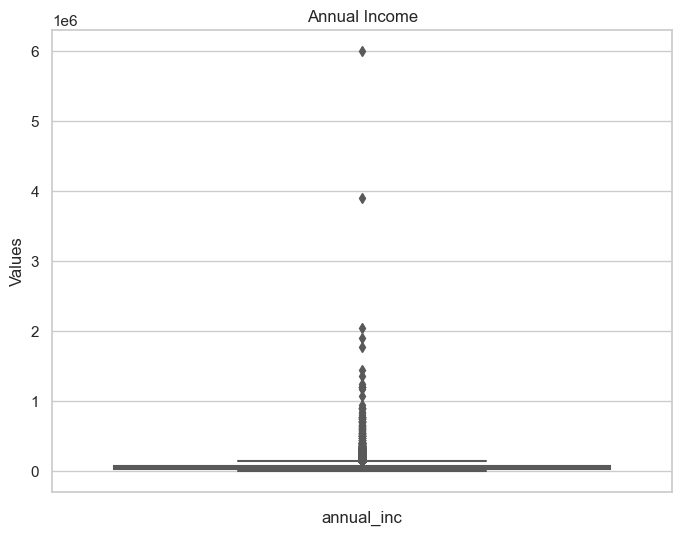

In [118]:
create_boxplot(df, 'annual_inc', title='Annual Income')


***As we can see there are a lot of outliers because of which the box isn't visibile either***

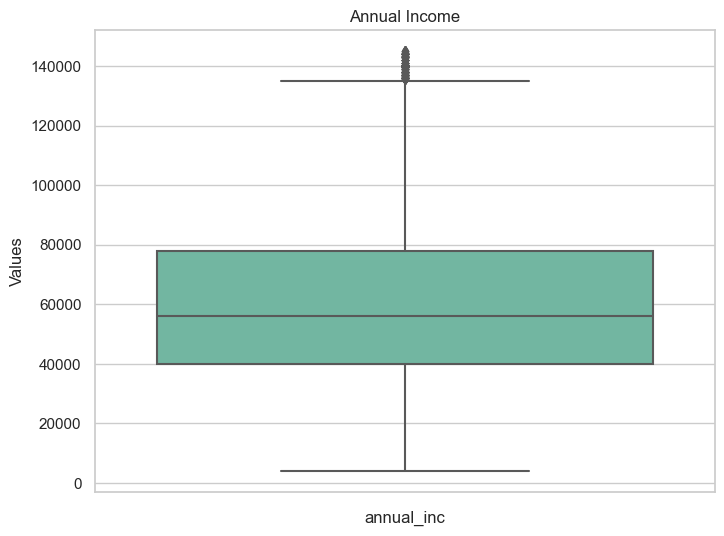

In [119]:
# Calculate the lower bound and upper bound and filter the rows
annual_inc_lb = calculate_boxplot_stats(df, 'annual_inc')['lower_bound']
annual_inc_ub = calculate_boxplot_stats(df, 'annual_inc')['upper_bound']
df = df[(df.annual_inc > annual_inc_lb) & (df.annual_inc < annual_inc_ub)]

create_boxplot(df, 'annual_inc', title='Annual Income')

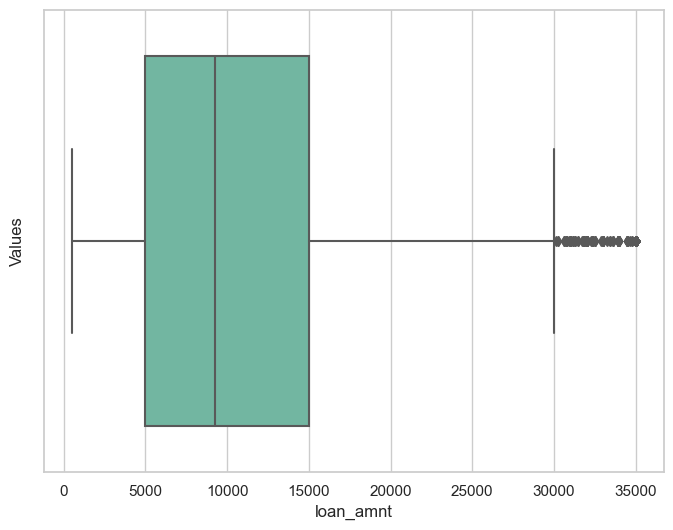

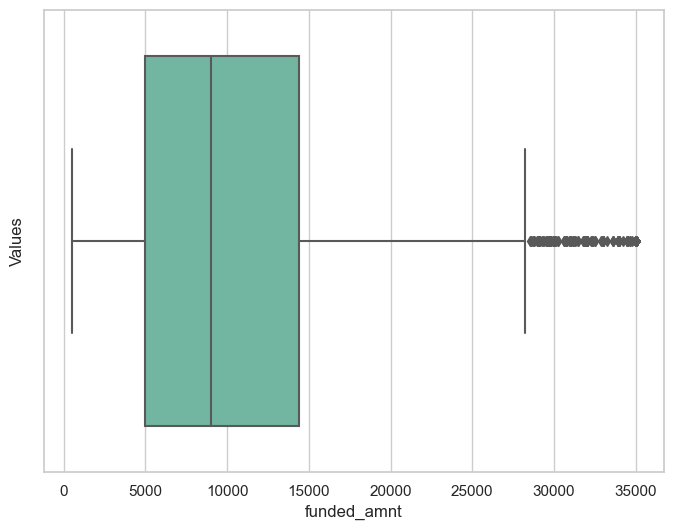

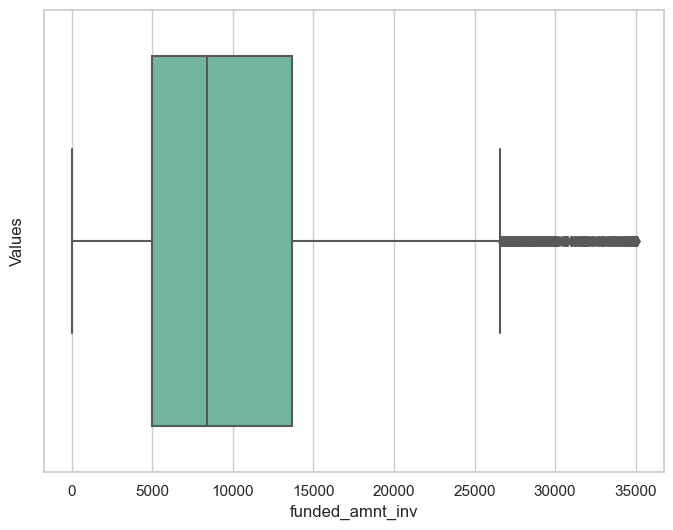

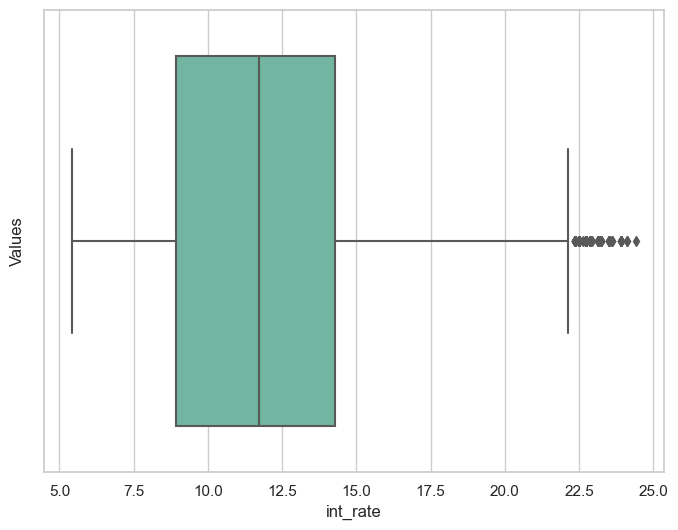

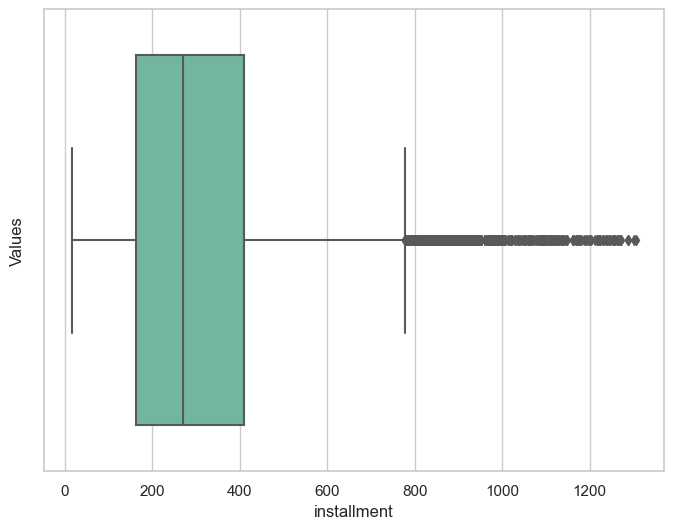

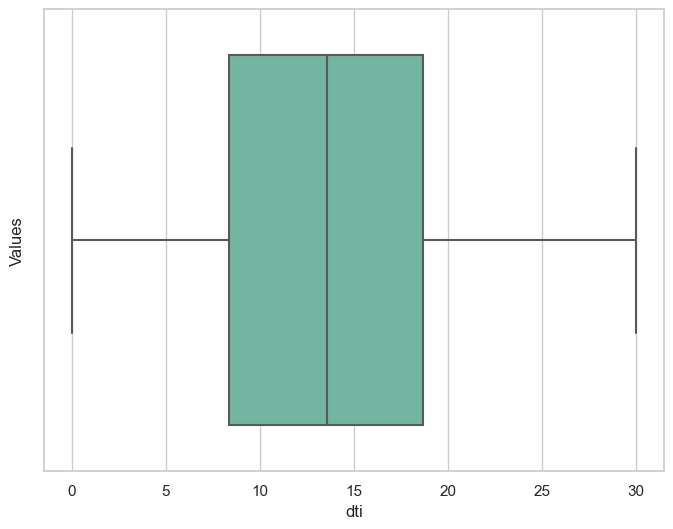

In [120]:
for col in ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'dti']:
    create_boxplot(df, col, horizontal=False)

- Most loan applicants typically earn an annual income ranging from 40,000 to 75,000 USD.
- The loan amounts sought by the majority of applicants fall between 5,000 and 15,000 USD.
- Typically, the funded amounts for most loan applicants range from 5,000 to 14,000 USD.
- Investors usually fund loan amounts for most applicants within the range of 5,000 to 14,000 USD.
- The interest rates on loans vary between 9% and 14%.
- Monthly installment amounts for loans typically range from 160 to 440 USD.
- Debt-to-income ratios for applicants generally fall between 8 and 18.

### Imputing values

In [121]:
df.isna().sum()

addr_state                 0
annual_inc                 0
dti                        0
emp_length              1015
funded_amnt                0
funded_amnt_inv            0
grade                      0
home_ownership             0
installment                0
int_rate                   0
issue_d                    0
loan_amnt                  0
loan_status                0
pub_rec_bankruptcies     660
purpose                    0
sub_grade                  0
term                       0
verification_status        0
loan_status_numeric        0
dtype: int64

***emp_length and pub_rec_bankruptcies are only columns with null values***

**emp_length being null would mean either they are not employed or self employed. Let's check their annual incomes, since annual income isn't null for any of the records**

In [122]:
#Find the most occuring annual inc of people whose emp length is missing
df[df.emp_length.isna()]['annual_inc'].mode()

0    36000.0
Name: annual_inc, dtype: float64

**Comparing this with the general annual_inc stats**

In [123]:
#Find the most occuring annual inc overall
df['annual_inc'].mode()

0    60000.0
Name: annual_inc, dtype: float64

In [124]:
#Find the most occuring emp length
df.emp_length.mode()[0]

10.0

**Since the annual income of folks with missing emp length is close to that of the overall dataset, we can safely assume that they would also have had similar employement duration** 

In [125]:
df.emp_length.fillna(df.emp_length.mode()[0], inplace=True)

In [126]:
# Verify if the imputation of values is successful
df.emp_length.isna().sum()
df.pub_rec_bankruptcies.value_counts()

pub_rec_bankruptcies
0.0    34488
1.0     1601
2.0        5
Name: count, dtype: int64

**With regards to pub_rec_bankruptcies, we have 661 records with no values. Let's check their annual incomes before taking a call**

In [127]:
print("Median of annual_inc for records with null bankruptcies")
print(df[df.pub_rec_bankruptcies.isna()]['annual_inc'].median())
print("Median of annual_inc for records for non null bankruptcies")
print(df[~df.pub_rec_bankruptcies.isna()].groupby(by='pub_rec_bankruptcies')['annual_inc'].agg(lambda x: x.median()))

Median of annual_inc for records with null bankruptcies
52000.0
Median of annual_inc for records for non null bankruptcies
pub_rec_bankruptcies
0.0    56000.0
1.0    56655.0
2.0    45600.0
Name: annual_inc, dtype: float64


**The median for null bankruptcies is 52000, which is lesser than 0 and 1 but more than people with 2 bankruptcies. We still can't make a viable decision on the bankruptcy information. The right approach would be to leave it as is.**

###### Imputing NONE values as OTHER for home_ownership

In [128]:
df['home_ownership'].replace('NONE', 'OTHER', inplace = True)

In [129]:
df.home_ownership.value_counts()

home_ownership
RENT        18050
MORTGAGE    15750
OWN          2858
OTHER          96
Name: count, dtype: int64

###### Replacing the 'Source Verified' values as 'Verified' since both values mean the same thing i.e. the loan applicant has some source of income which is verified

In [130]:
df['verification_status'].replace('Source Verified', 'Verified', inplace = True)

## 3. Data Analysis

### 3.1 Derive columns

In [131]:
# Extracting Month and Year for analysis from issue_d
df['issue_m'] = pd.DatetimeIndex(df['issue_d']).month
df['issue_y'] = pd.DatetimeIndex(df['issue_d']).year

In [132]:
# Categorising Months into quaterly buckets
threshold_months = [4, 7, 10]
quarter_labels = ['Q1', 'Q2', 'Q3', 'Q4']
df['issue_q'] = df['issue_m'].apply(bucket_data, args=(threshold_months, quarter_labels))

In [133]:
# Create loan paid, where Fully Paid is a Yes and Charged Off is a No
loan_status_map = {'Charged Off': 'No', 'Fully Paid': 'Yes' }
df['loan_paid'] = df['loan_status'].map(loan_status_map)

In [134]:
df['loan_amnt'].value_counts().sort_values(ascending=True)

loan_amnt
15650.0       1
6675.0        1
3225.0        1
7625.0        1
21300.0       1
           ... 
15000.0    1717
6000.0     1842
5000.0     1985
12000.0    2152
10000.0    2696
Name: count, Length: 854, dtype: int64

In [135]:
# Categorising Loan Amount
loan_amount_thresholds = [5000, 10000, 15000, 20000, 25000, 30000]
loan_amount_labels = ['0 - 5K', '5K - 10K', '10K - 15K', '15K - 20K', '20K - 25K', '25K - 30K' , '30K - above']
df['loan_amnt_bucket'] = df['loan_amnt'].apply(bucket_data, args=(loan_amount_thresholds, loan_amount_labels))

In [136]:
df[['loan_amnt','loan_amnt_bucket']]

,loan_amnt,loan_amnt_bucket
0,5000.0,5K - 10K
1,2500.0,0 - 5K
2,2400.0,0 - 5K
3,10000.0,10K - 15K
5,5000.0,5K - 10K
...,...,...
39711,5000.0,5K - 10K
39712,2500.0,0 - 5K
39713,8500.0,5K - 10K
39714,5000.0,5K - 10K


In [137]:
# Categorising int_rate
int_rate_bins = [5, 9, 13, 17, 21]
int_rate_labels = ['0%-5%', '5%-9%','9%-13%','13%-17%','17%-21%','21%-25%']
df['int_rate_bucket'] = df['int_rate'].apply(bucket_data, args=((int_rate_bins, int_rate_labels)))

In [138]:
# Categorising Annual Income
annual_inc_thresholds = [40000, 50000, 60000, 70000, 80000]
annual_inc_labels = ['0 - 40k', '40k - 50k', '50k - 60k', '60k - 70k', '70k - 80k', '80k - above']
df['annual_inc_bucket'] = df['annual_inc'].apply(bucket_data, args=(annual_inc_thresholds, annual_inc_labels))

In [139]:
# Categorizing Funded Amount
funded_amnt_thresholds = [5000, 10000, 15000]
funded_amnt_labels = ['0 - 5k', '5k - 10k', '10k - 15k', '15k - above']
df['funded_amnt_bucket'] = df['funded_amnt'].apply(bucket_data, args=(funded_amnt_thresholds, funded_amnt_labels))

In [140]:
# Categorising DTI
dti_thresholds = [8, 12, 16, 20]
dti_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df['dti_bucket'] = df['dti'].apply(bucket_data, args=(dti_thresholds, dti_labels))

### 3.2 Univariate Analysis

#### 1. Categorical variables
    1. Ordered categorical data
        1. Employment length (emp_length)
        2. Grade (grade)
        3. Issue month (issue_m)
        4. Issue quarter (issue_q)
        5. Issue year (issue_y)
        6. Sub grade (sub_grade)
        7. Term (36 / 60 months) (term)

    2. Unordered categorical data
        1. Home Ownership (home_ownership)
        4. Loan purpose (purpose)
    
#### 2. Quantitative variables
    1. Annual income bucket (annual_inc_bucket)
    2. Debt to Income Ratio (DTI) bucket (dti_bucket)
    3. Funded amount bucket (funded_amnt_bucket)
    4. Interest rate bucket (int_rate_bucket)
    5. Loan amount bucket (loan_amnt_bucket)
    6. Monthly Installment (installment)
    

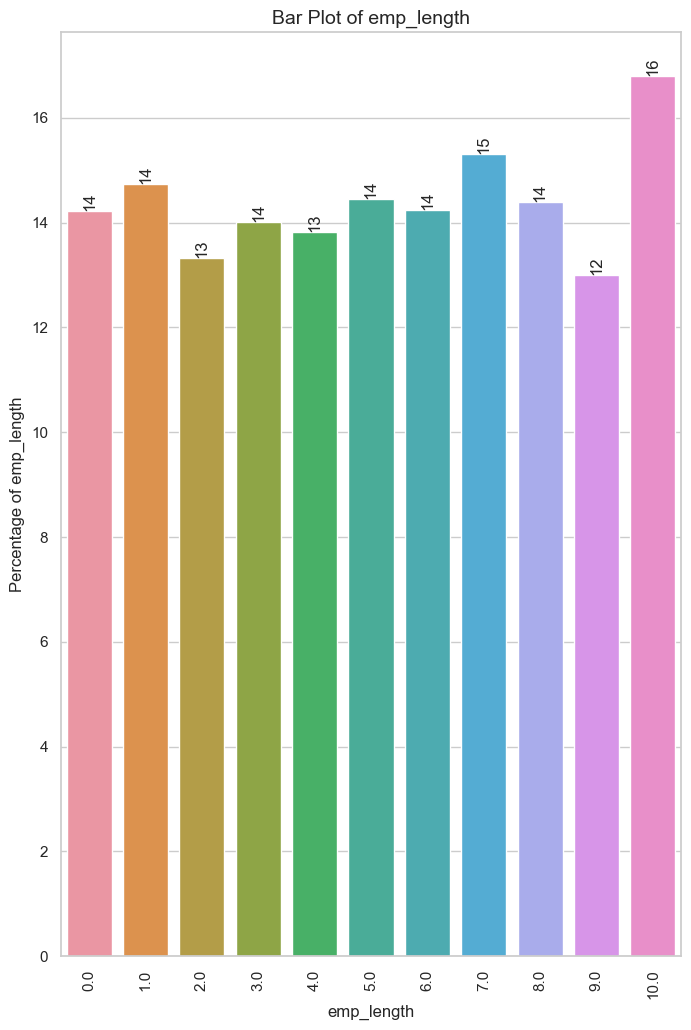

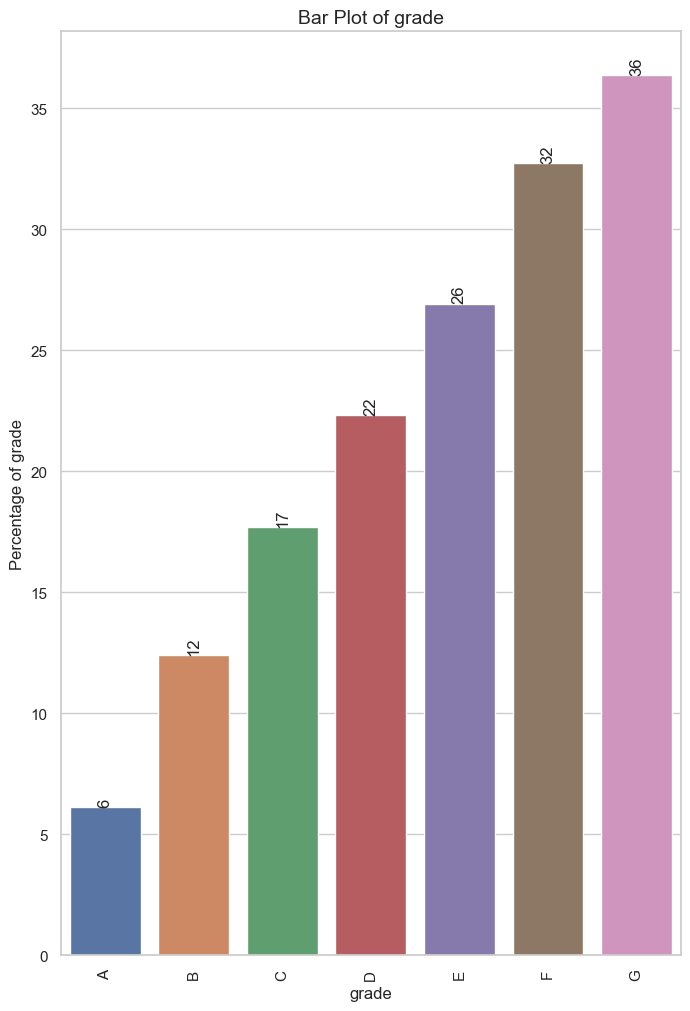

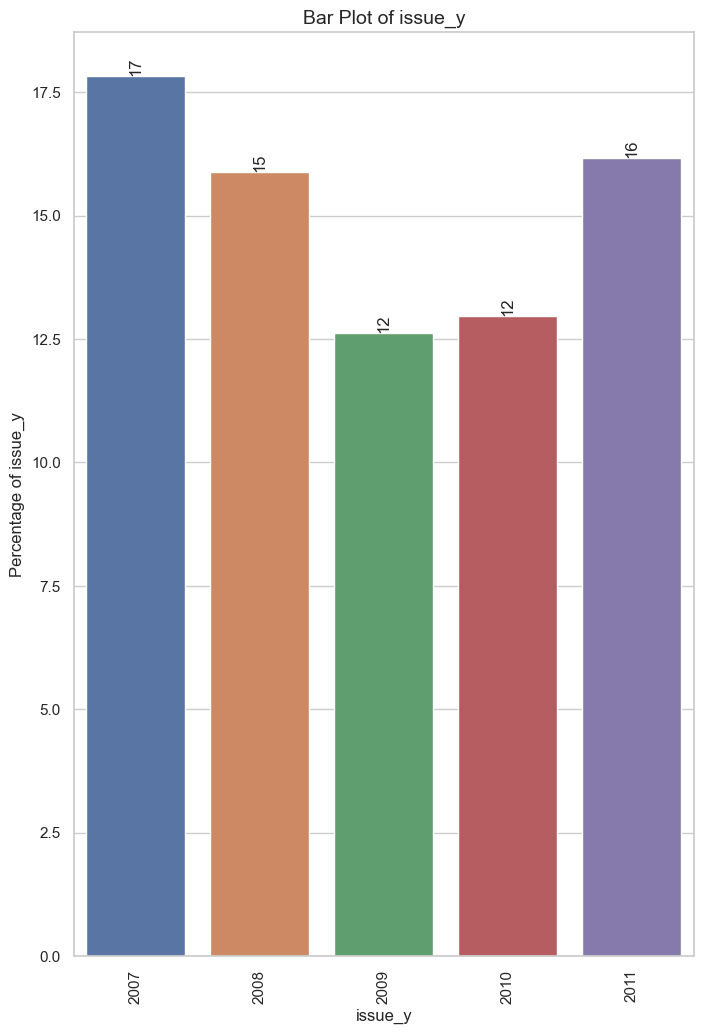

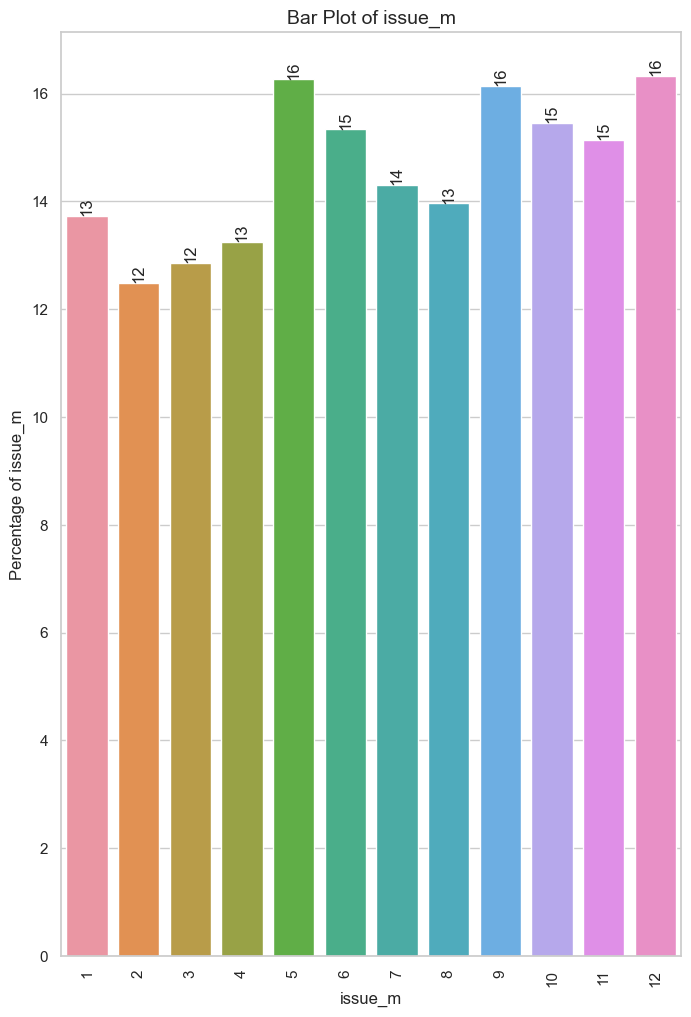

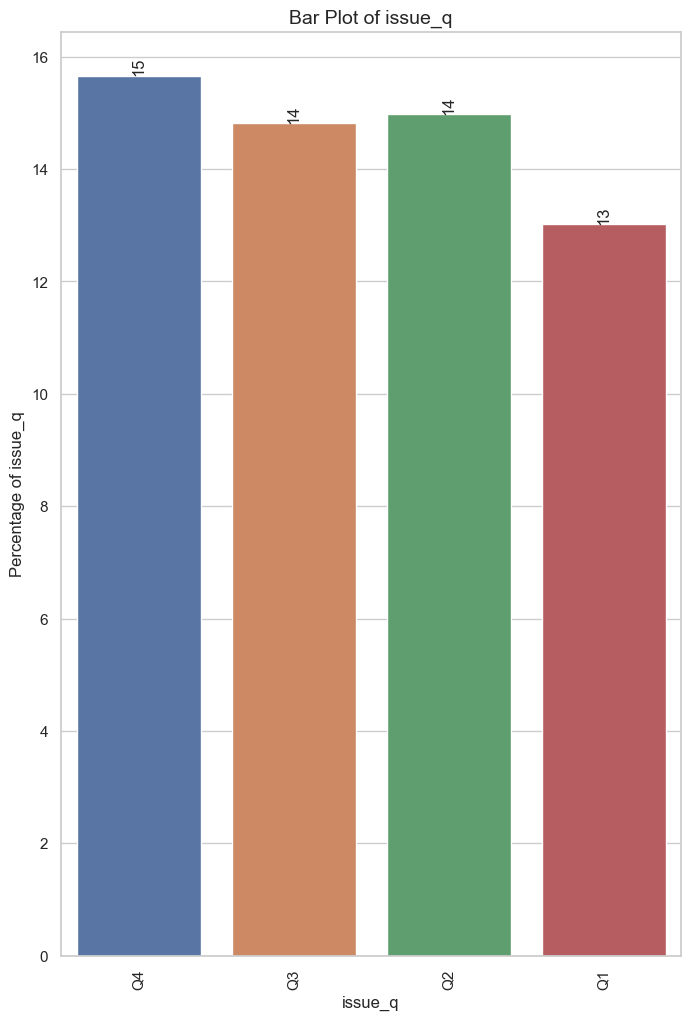

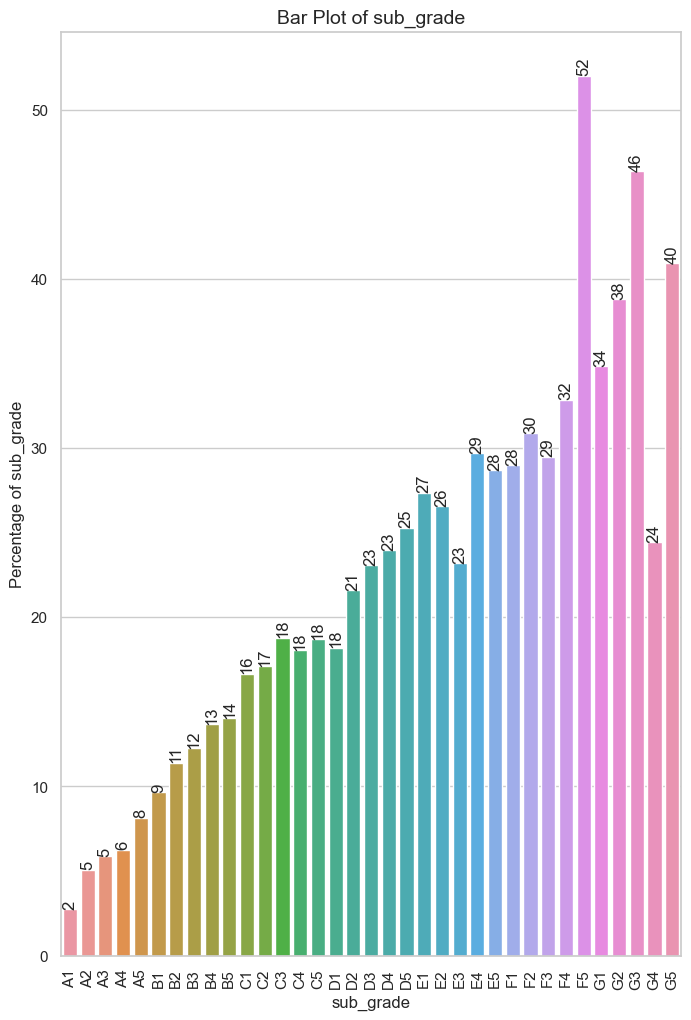

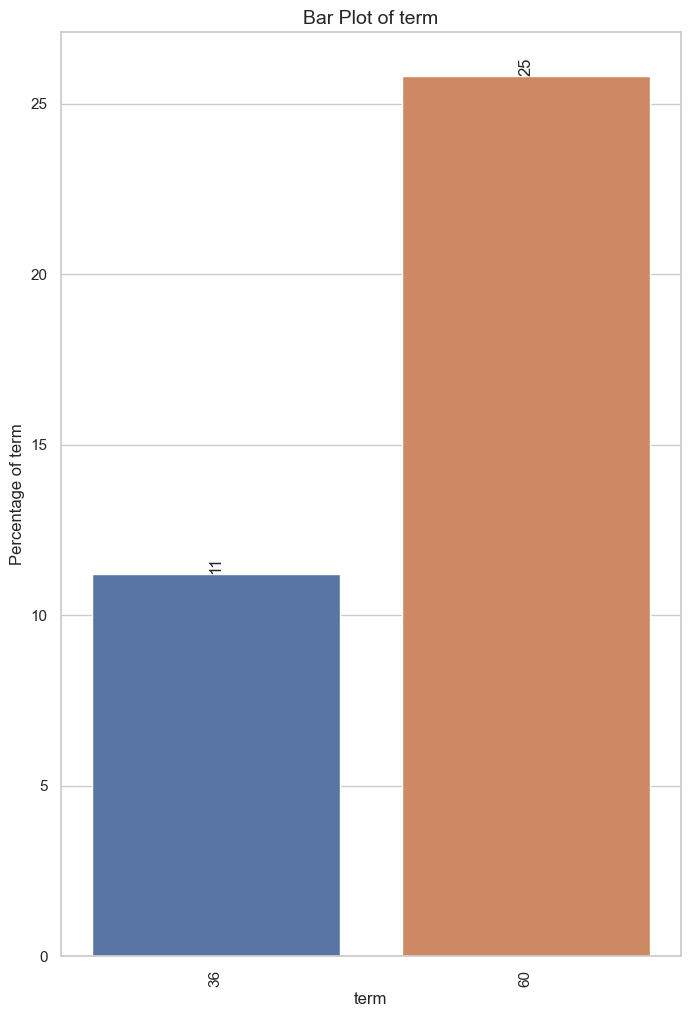

In [141]:
## Ordered categorical data

for var in ['emp_length','grade', 'issue_y', 'issue_m', 'issue_q', 'sub_grade', 'term']:
    plot_bar_graph(
        df,
        x_column = var,
        y_column = var,
        title = f'Bar Plot of {var}',
        xlabel = var,
        ylabel=f'Percentage of {var}',
        figsize=(8, 12),
        x_tick_rotation=90,
        freq_rotation=90,
        filter_column='loan_paid',
        filter_value='No'
    )

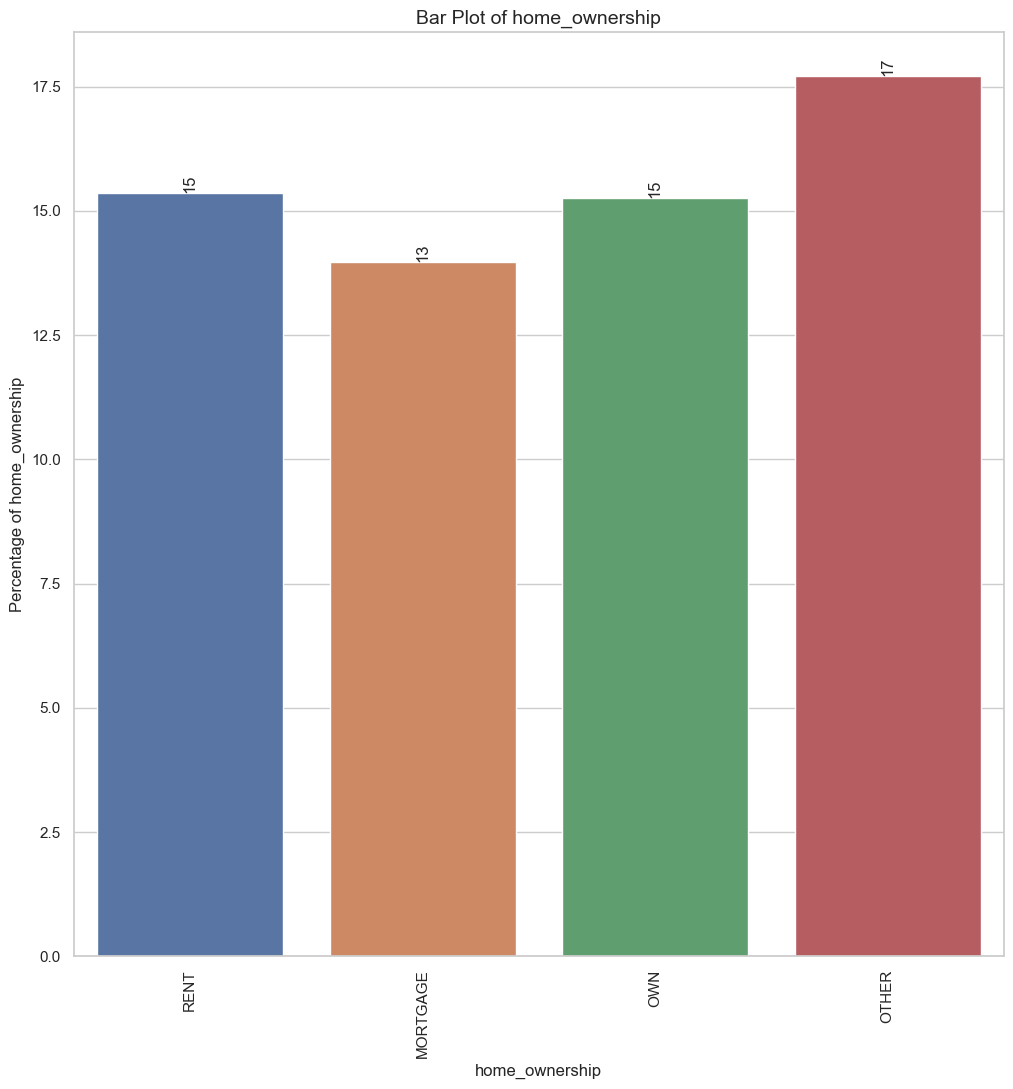

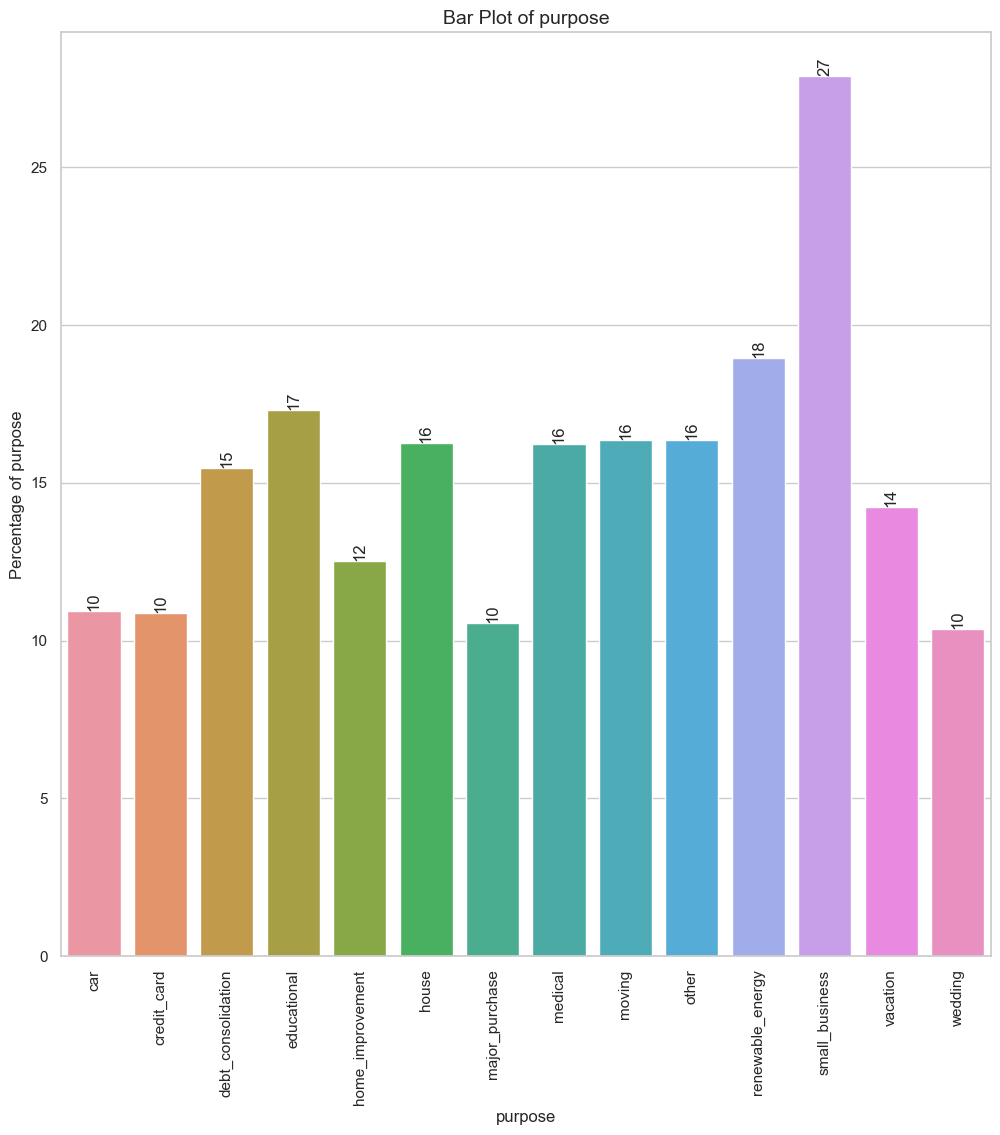

In [142]:
## Unordered categorical data

for var in ['home_ownership', 'purpose']:
    plot_bar_graph(
        df,
        x_column = var,
        y_column = var,
        title = f'Bar Plot of {var}',
        xlabel = var,
        ylabel=f'Percentage of {var}',
        figsize=(12, 12),
        x_tick_rotation=90,
        freq_rotation=90,
        filter_column='loan_paid',
        filter_value='No'
    )

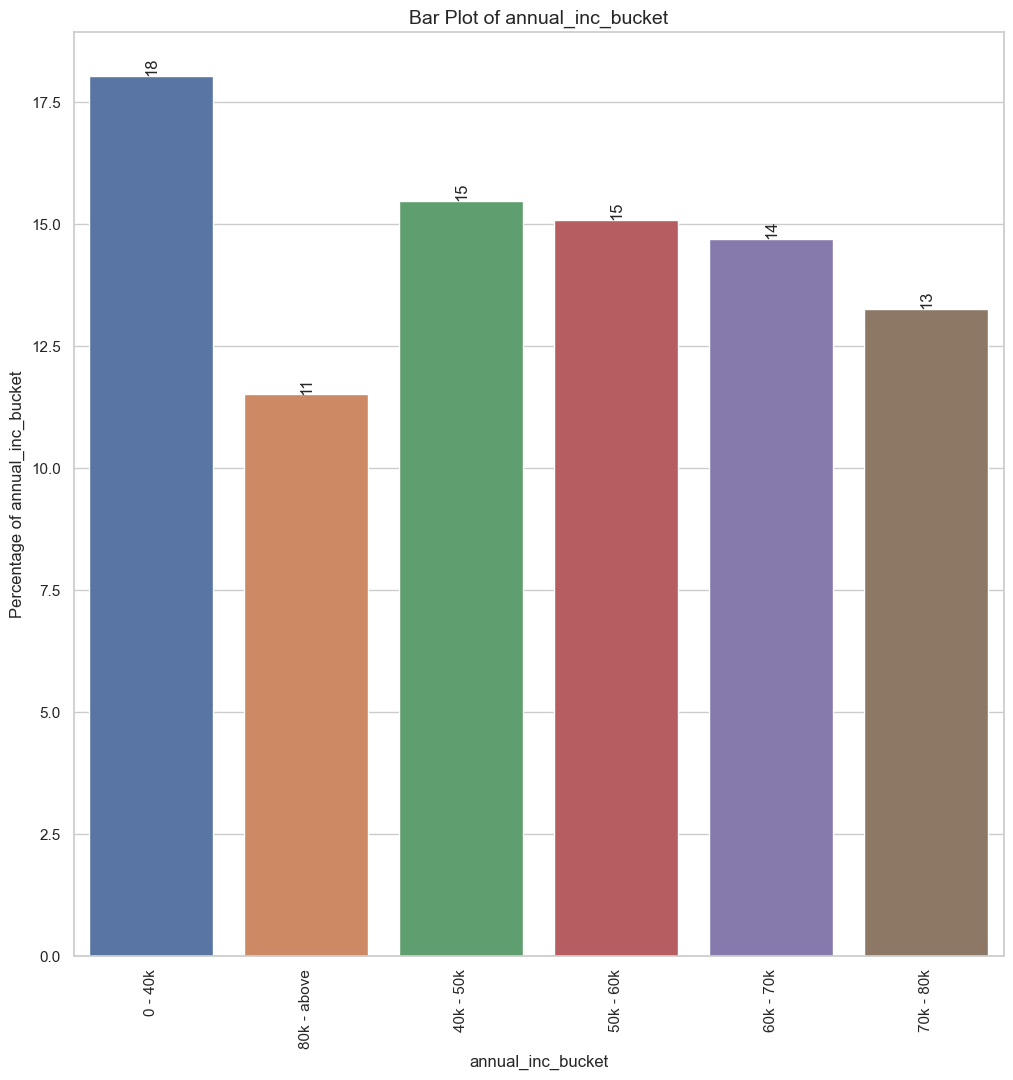

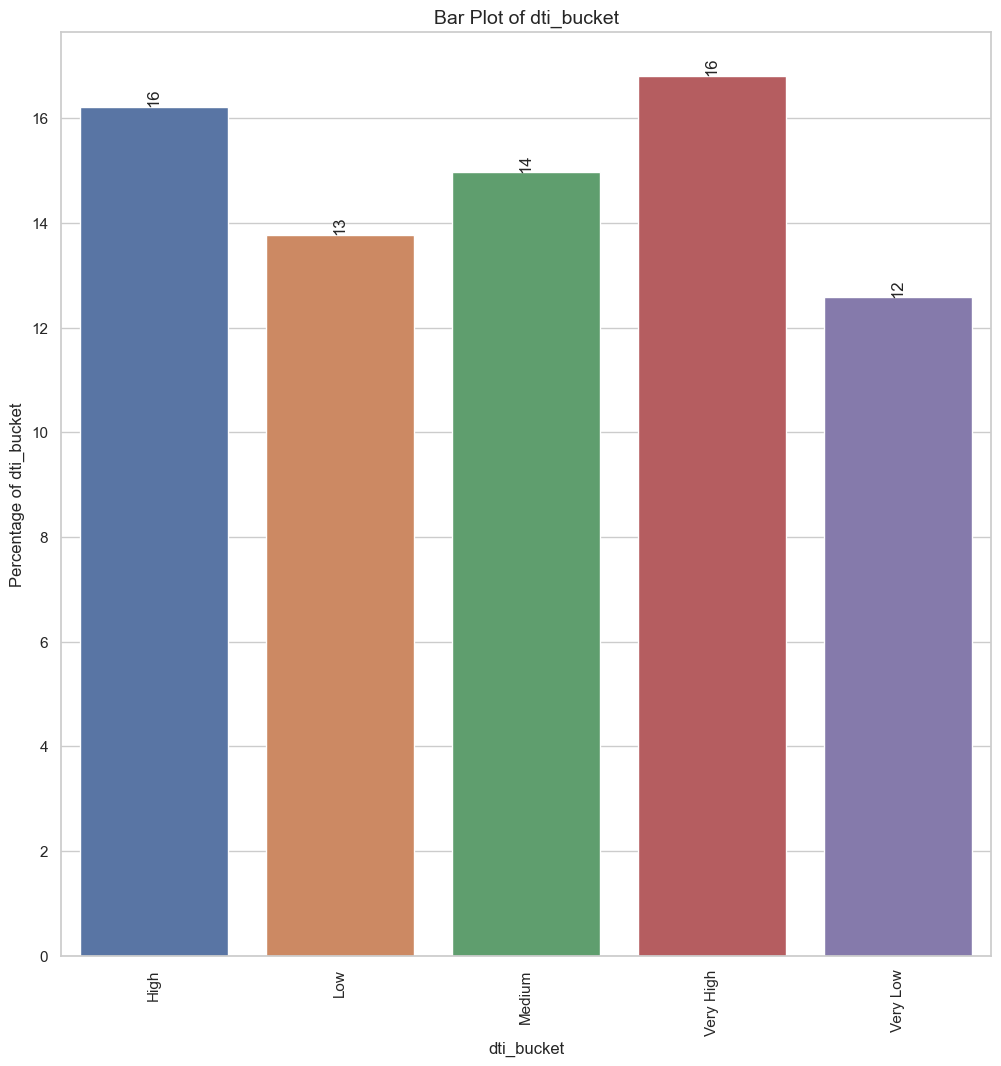

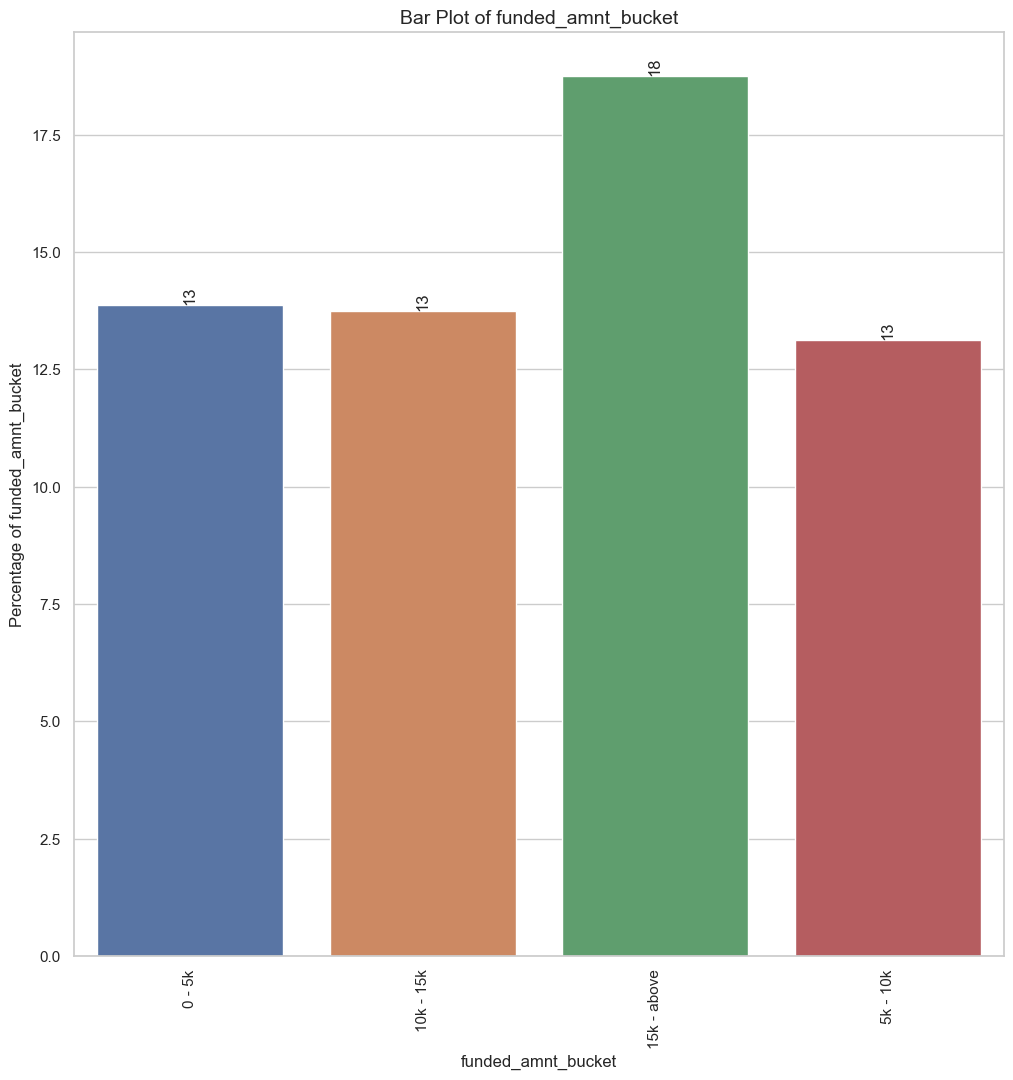

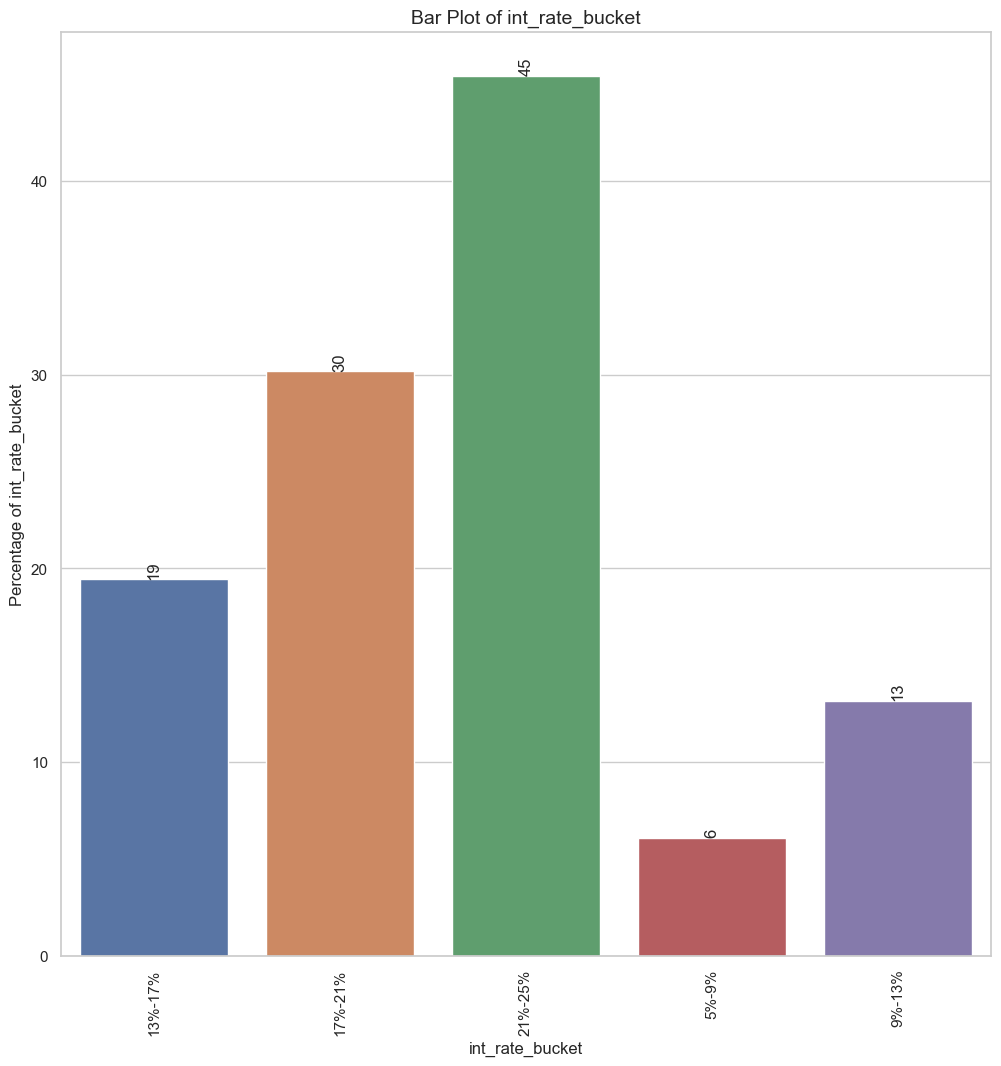

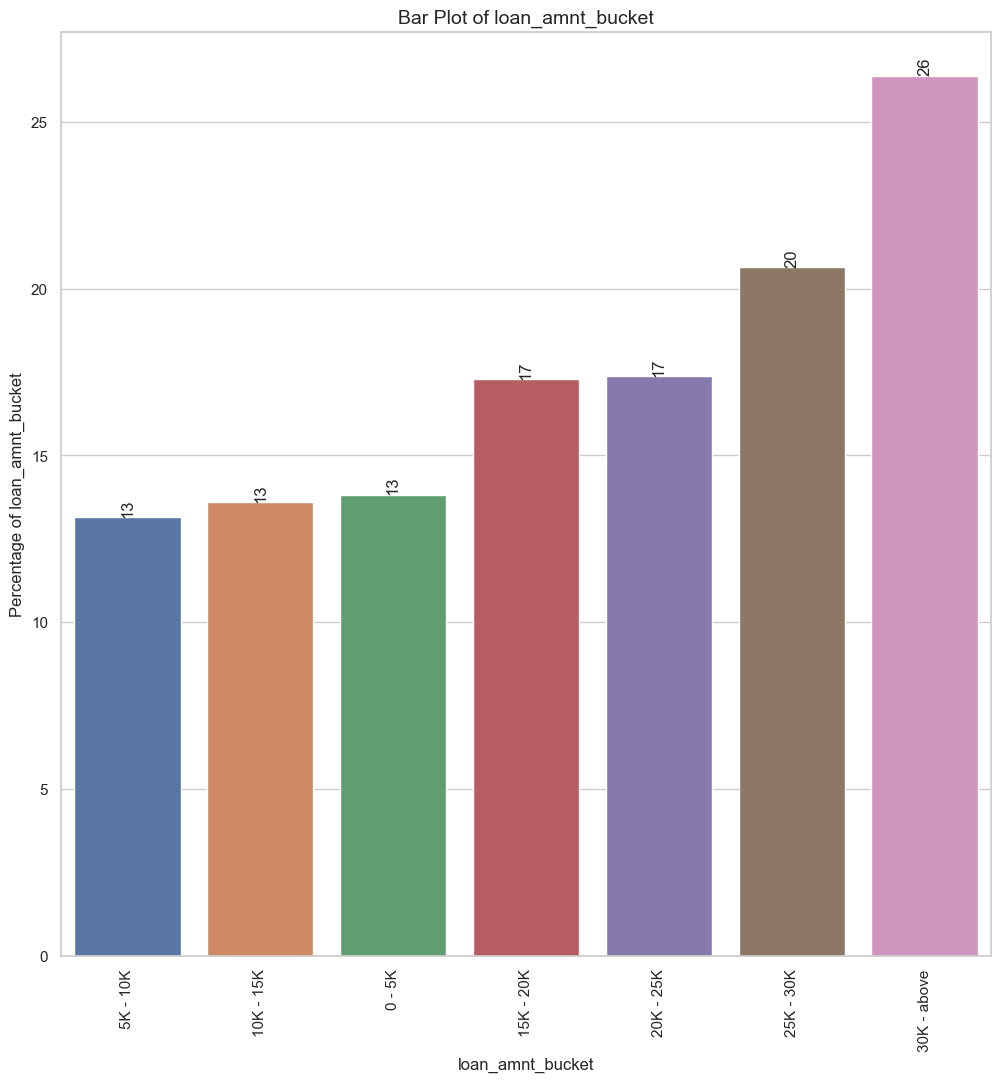

In [143]:
## Quantitative variables

for var in ['annual_inc_bucket', 'dti_bucket', 'funded_amnt_bucket', 'int_rate_bucket', 'loan_amnt_bucket']:
    plot_bar_graph(
        df,
        x_column = var,
        y_column = var,
        title = f'Bar Plot of {var}',
        xlabel = var,
        ylabel=f'Percentage of {var}',
        figsize=(12, 12),
        x_tick_rotation=90,
        freq_rotation=90,
        filter_column='loan_paid',
        filter_value='No'
    )

In [144]:
installments_df = df[df.loan_paid == 'No']

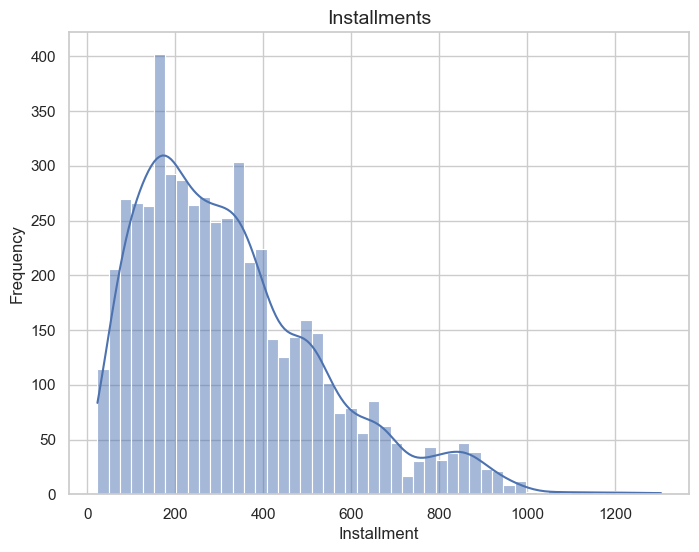

In [145]:
plot_histogram(installments_df, column='installment', bins=50, title='Installments', xlabel='Installment', ylabel='Frequency')

#### Observations
- Individuals with 10 or more years of work experience exhibit the highest default rate.
- Loans graded as G demonstrate the highest default rate.
- The year 2007 emerges with the highest default percentage.
- Default rates peak in May, September, and December.
- The first quarter, covering January to March, consistently records the highest default rate.
- Loans classified as Subgrade F5 display the highest default percentage, with 52% remaining unpaid.
- Loan terms spanning 60 months exhibit the highest default rate.
- Loans without defined homeownership exhibit the highest default rate.
- Small business loans have the highest default percentage.
- Individuals earning less than 40k annually display a higher tendency to default.
- Higher Debt-To-Income ratios correlate with increased default likelihood.
- Default percentage is highest for funded amounts exceeding 15k.
- Default percentage increases with higher interest rates.
- Default percentage rises with larger loan amounts.
- Among charged-off loan participants, a majority fall within the monthly installment range of 160-440 USD. It is advisable for the lending company to closely monitor and evaluate applicants with similar installment amounts to mitigate the risk of loan defaults.


### 3.3. Bivariate Analysis

Following fields will be analysed as part of bivariate analysis against Loan Paid (`loan_paid`) column

#### 1. Categorical variables
    1. Ordered categorical data
        1. Employment length (emp_length)
        2. Grade (grade)
        3. Issue month (issue_m)
        4. Issue quarter (issue_q)
        5. Issue year (issue_y)
        6. Sub grade (sub_grade)
        7. Term (36 / 60 months) (term)

    2. Unordered categorical data
        1. Home Ownership (home_ownership)
        4. Loan purpose (purpose)
    
#### 2. Quantitative variables
    1. Annual income bucket (annual_inc_bucket)
    2. Debt to Income Ratio (DTI) bucket (dti_bucket)
    3. Funded amount bucket (funded_amnt_bucket)
    4. Interest rate bucket (int_rate_bucket)
    5. Loan amount bucket (loan_amnt_bucket)
    6. Monthly Installment (installment)


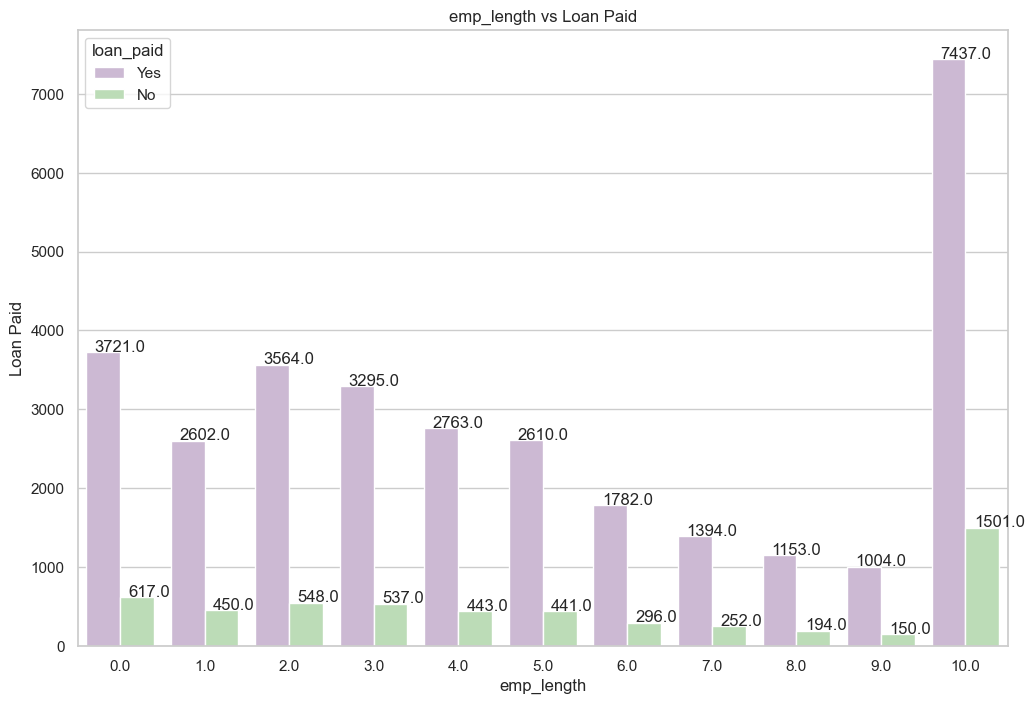

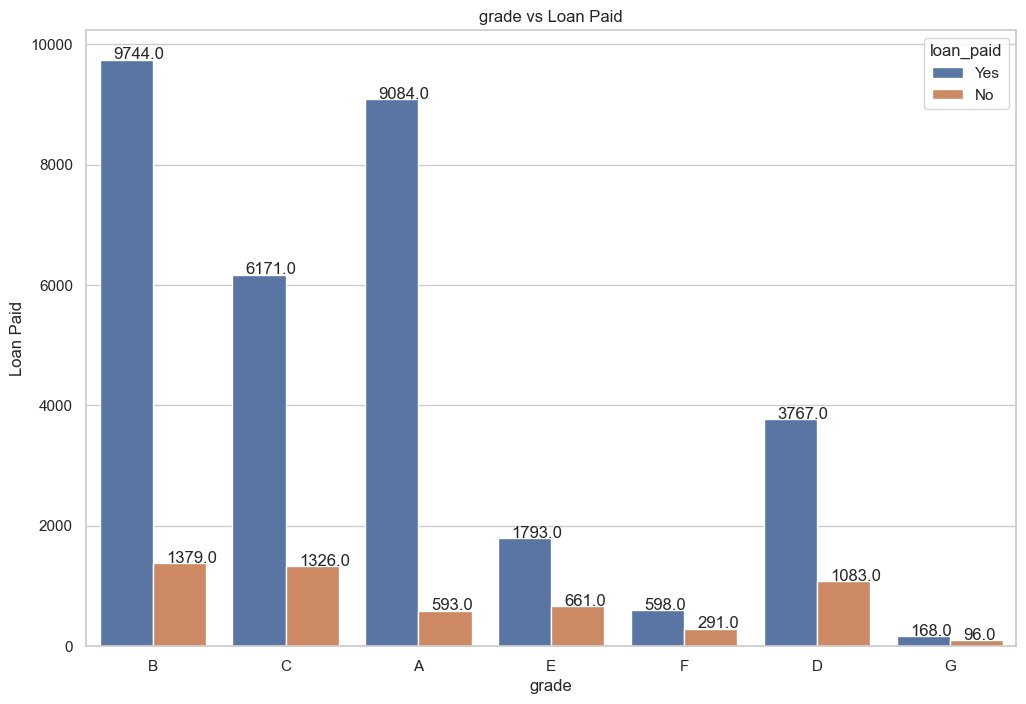

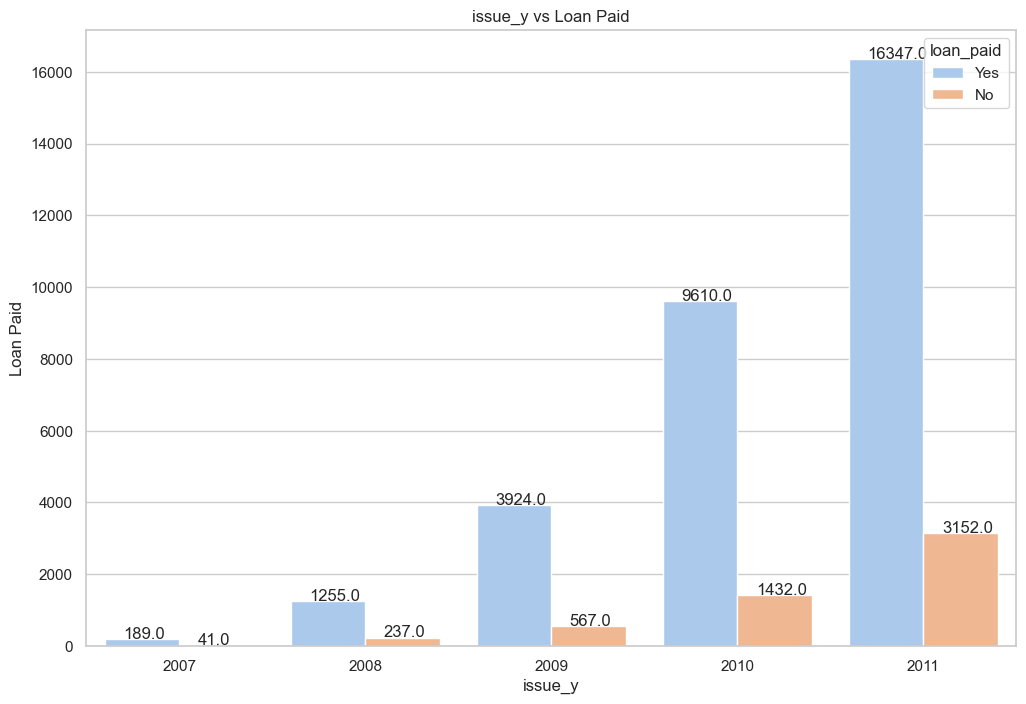

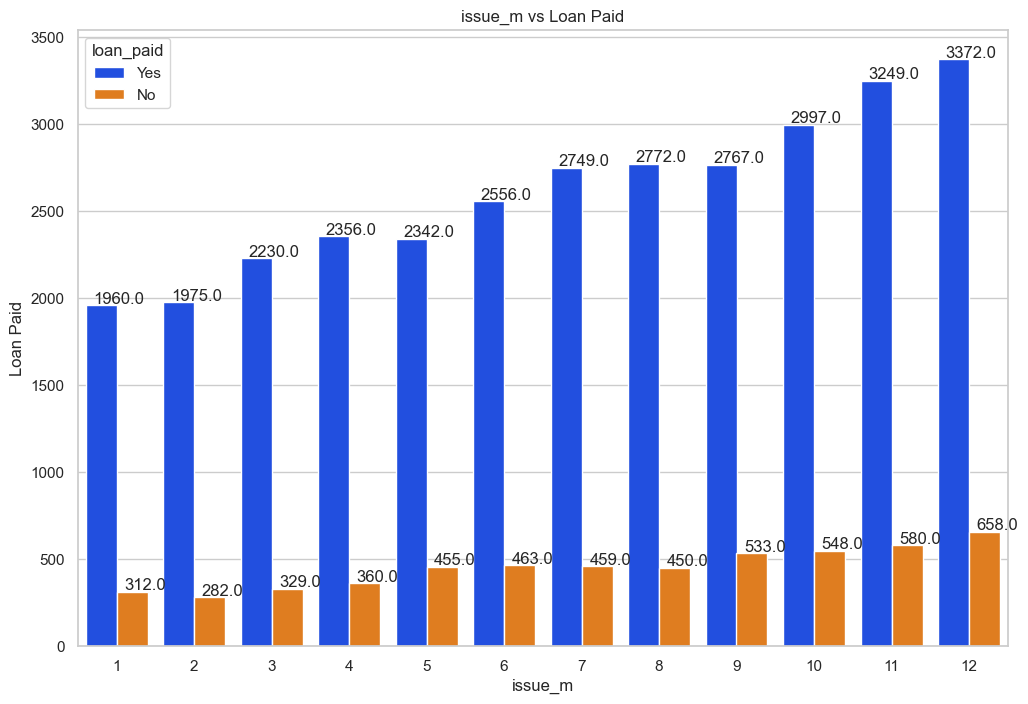

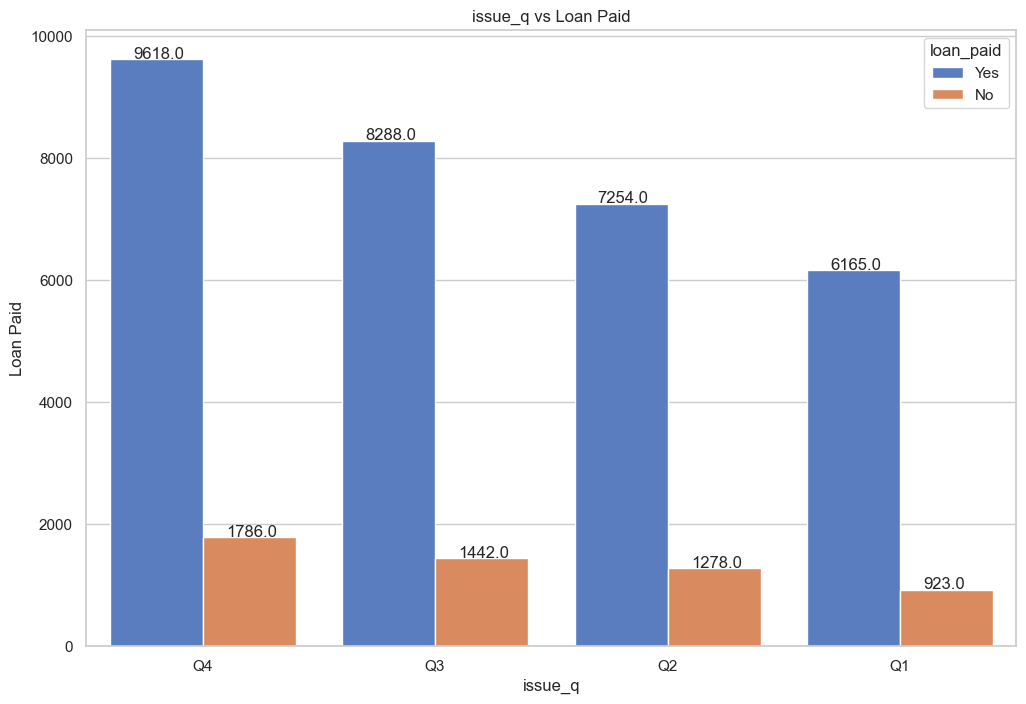

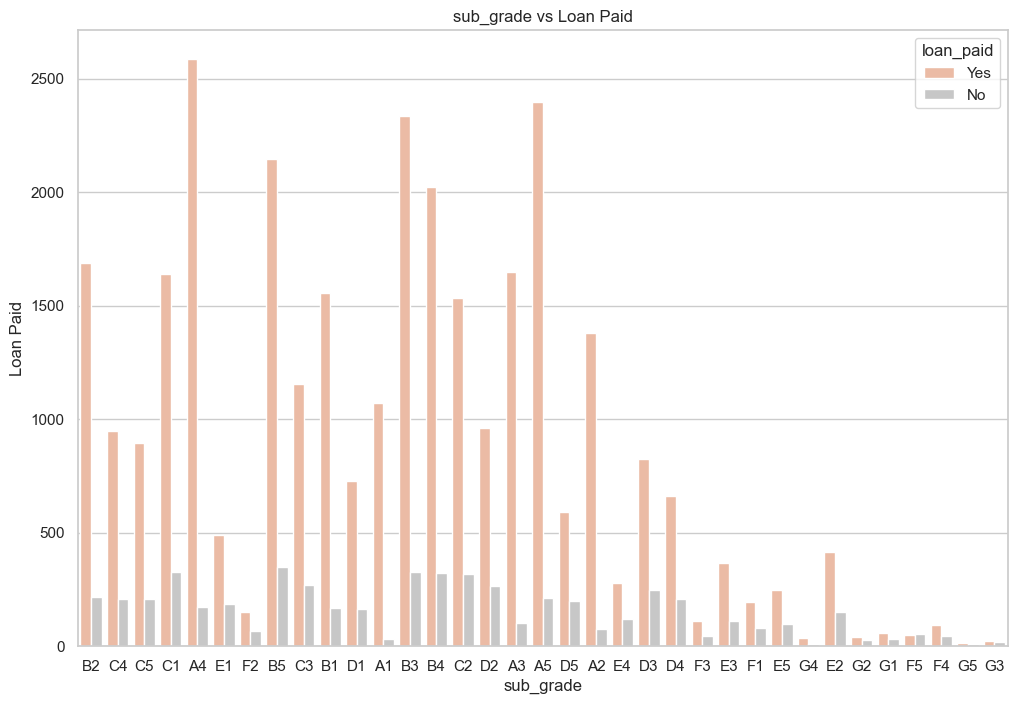

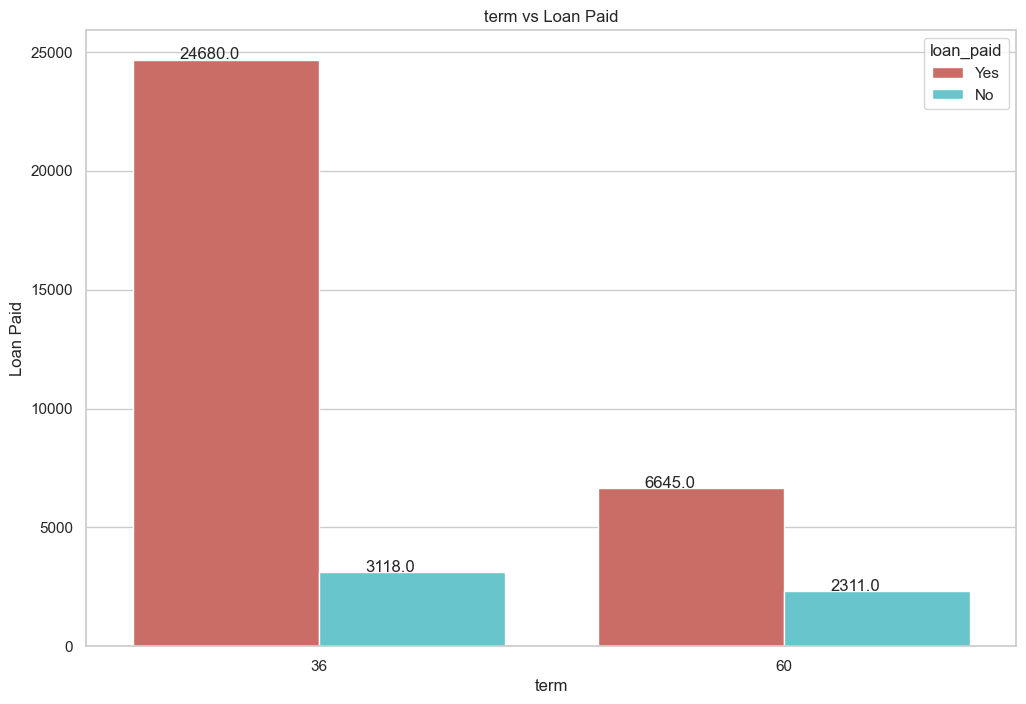

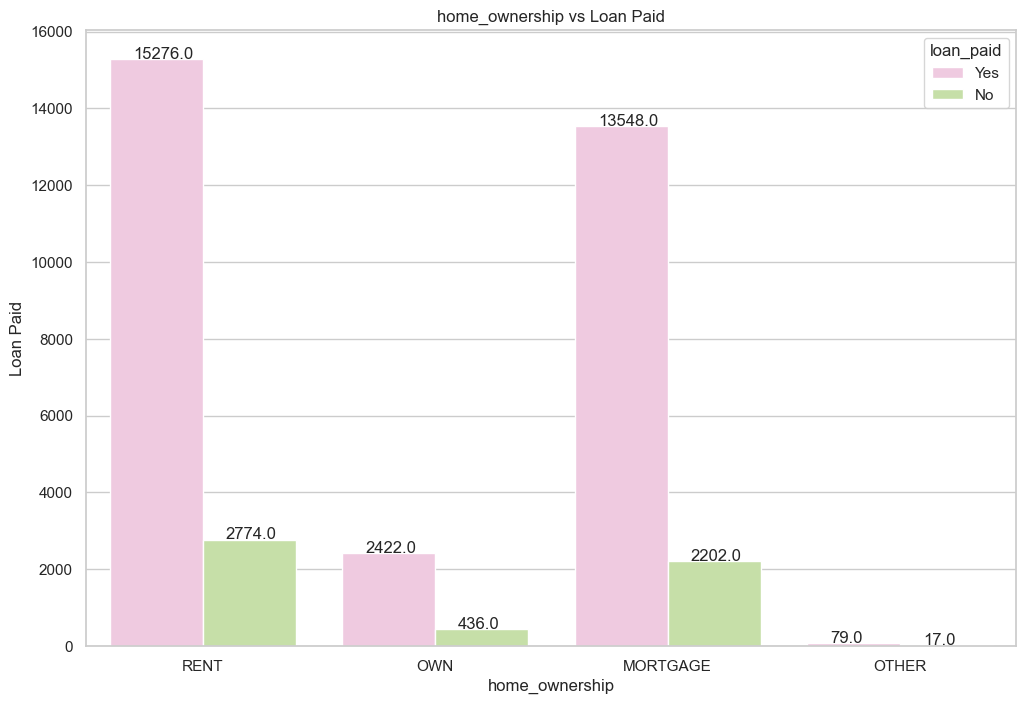

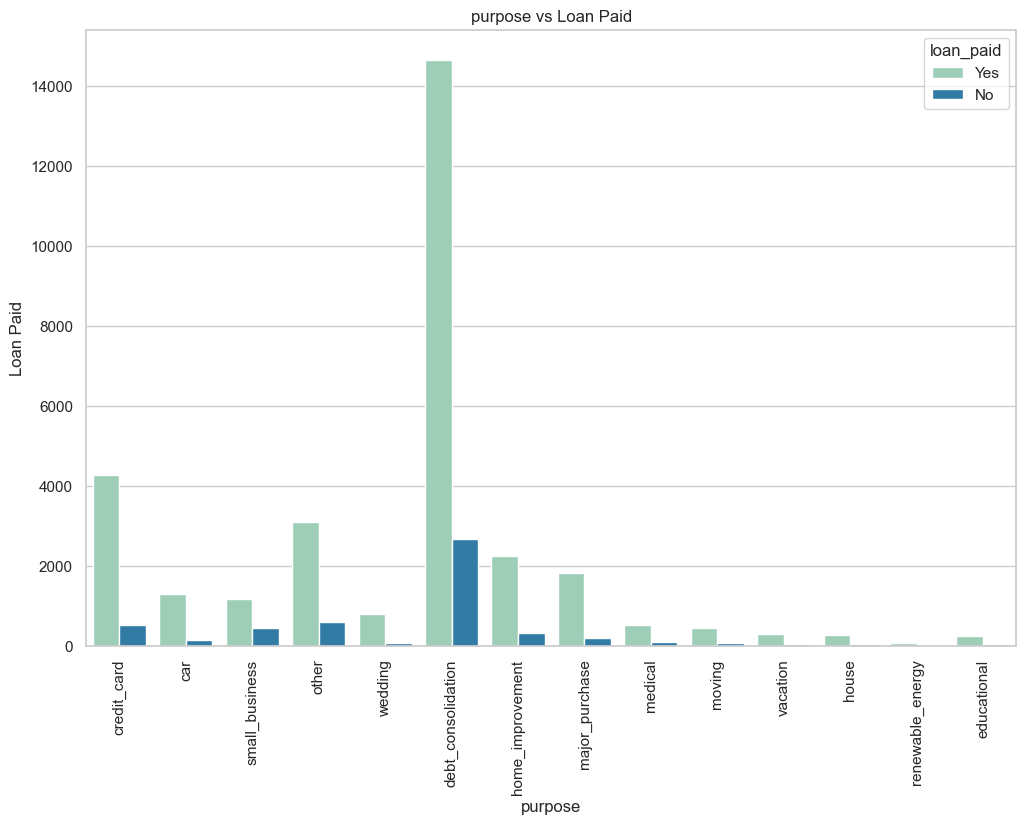

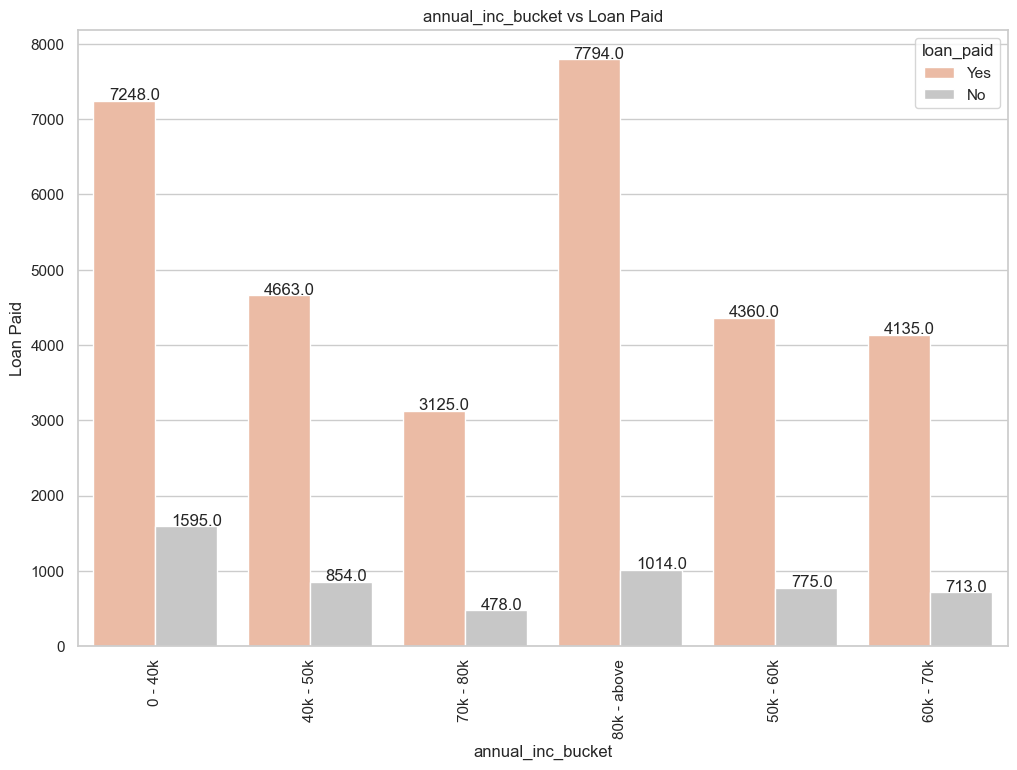

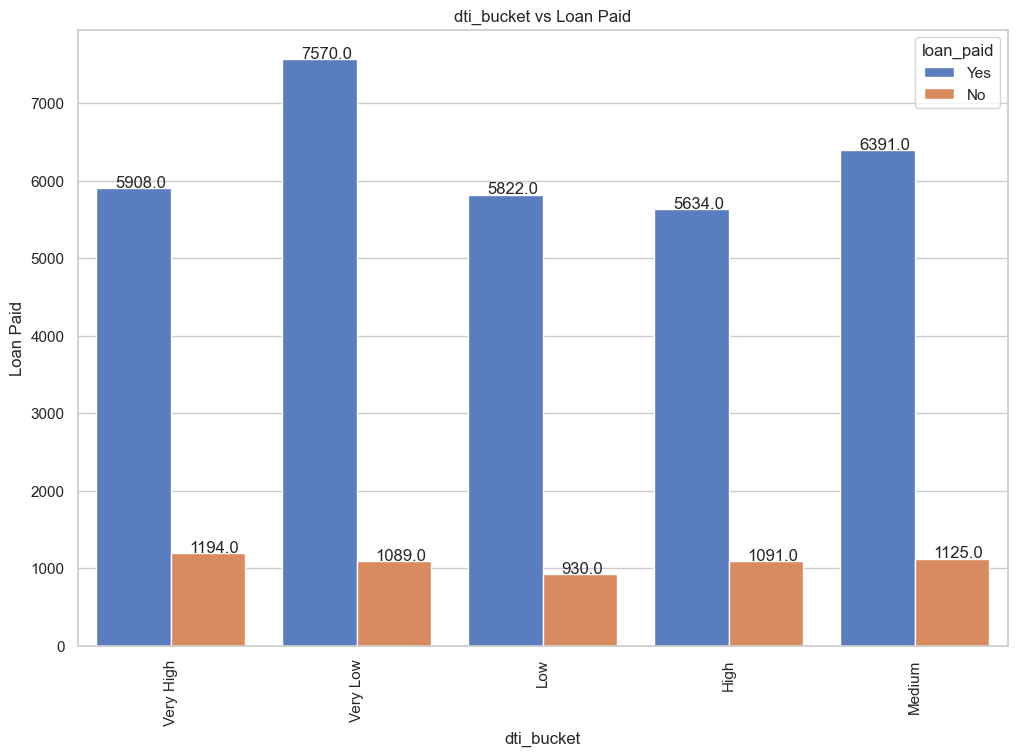

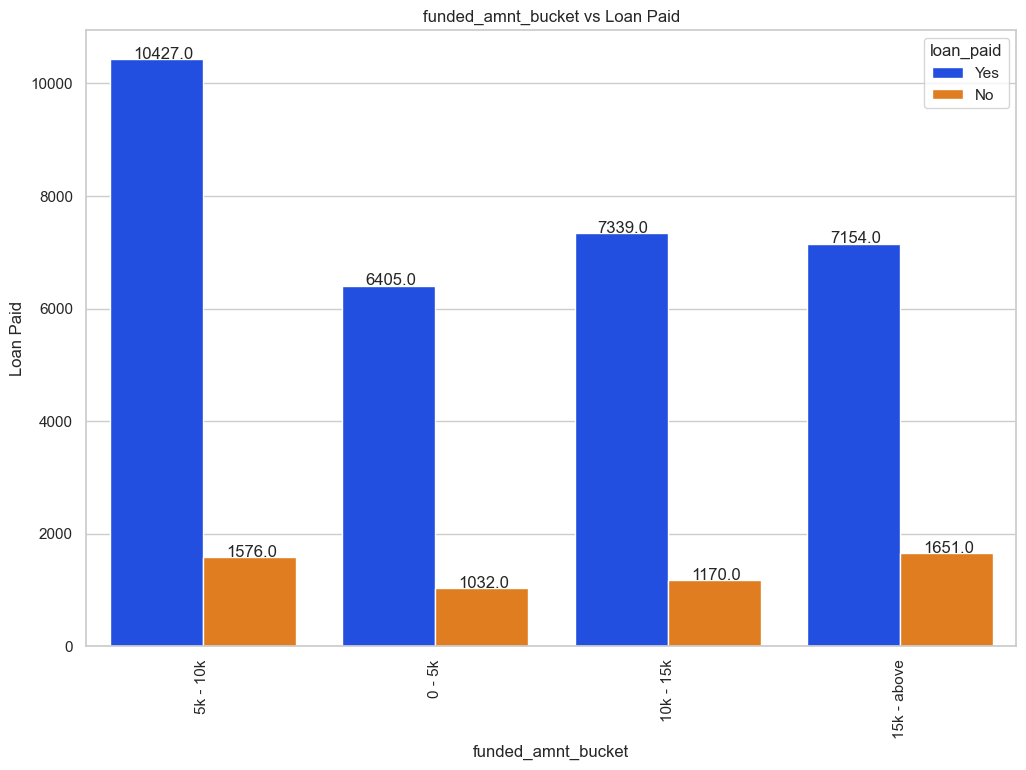

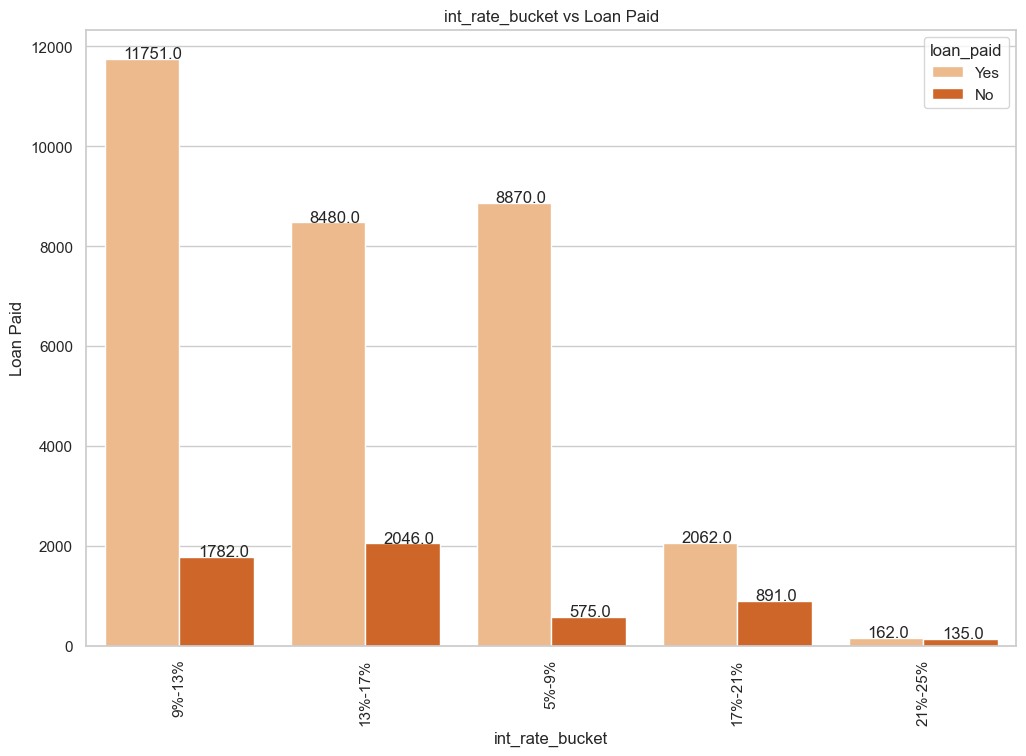

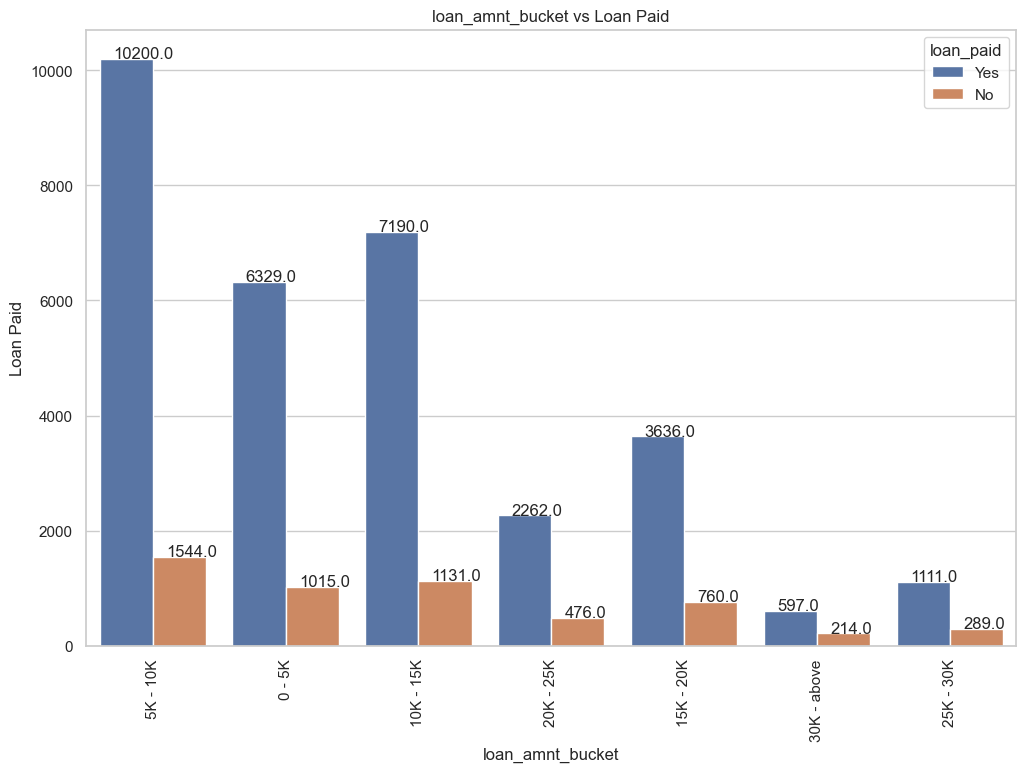

In [146]:
for var in [['emp_length', 'PRGn', True, 0],['grade', 'deep', True, 0], 
            ['issue_y', 'pastel', True, 0], ['issue_m', 'bright', True, 0], 
            ['issue_q', 'muted', True, 0], ['sub_grade', 'RdGy', False, 0], 
            ['term', 'hls', True, 0], ['home_ownership', 'PiYG', True, 0], ['purpose', 'YlGnBu', False, 90],
            ['annual_inc_bucket','RdGy', True, 90 ], ['dti_bucket','muted', True, 90], ['funded_amnt_bucket','bright', True, 90], ['int_rate_bucket','Oranges', True, 90], ['loan_amnt_bucket','deep', True, 90]
           ]:
    
    countplot_graph({
    'data': df,
    'x': var[0],
    'figsize': (12, 8),
    'hue': 'loan_paid',
    'xlabel': var[0],
    'ylabel': 'Loan Paid',
    'title': f'{var[0]} vs Loan Paid',
    'palette': var[1],
    'x_tick_rotation': var[3]    
        
},  annot = var[2])

## Summary of Bivariate Analysis

- Grades B, C, and D are associated with the highest percentage of "Charged Off" loans among loan applicants.
- Subgrades B3, B4, and B5 exhibit a higher propensity for charge-offs.
- 60-month term loans are correlated with a higher default rate compared to 36-month term loans.
- Applicants with ten or more years of experience are more likely to default.
- The number of loan applicants has shown a steady increase from 2007 to 2011.
- December and the fourth quarter (Q4) are popular periods for loan applications.
- Debt consolidation category sees the highest number of loans issued and defaults.
- Renters or mortgagees are more likely to default.
- Verified loan applicants show higher default rates.
- Most defaulted applicants received loan amounts of 15,000 USD or higher.
- High Debt-to-Income (DTI) ratios and interest rates in the range of 13%-17% are associated with defaults.
- Majority of defaulted applicants report annual incomes below 40,000 USD.

## Inferences of Bivariate Analysis

- Grades B, C, and D require stricter risk assessment and underwriting criteria.
- Special attention is needed for Subgrades B3, B4, and B5 applicants.
- Risk associated with longer-term loans needs evaluation.
- Experience alone may not be indicative of creditworthiness.
- Positive growth trend indicates market expansion opportunities.
- Increased demand during December and Q4 requires efficient processing.
- Debt consolidation loans necessitate careful evaluation and risk mitigation.
- Housing status should be considered in underwriting decisions.
- Verification processes may need enhancement.
- Thorough assessments are needed for larger loan requests.
- Interest rates should be adjusted based on DTI ratios.
- Affordability measures should be implemented based on income levels.


## 4. Multivariate Analysis

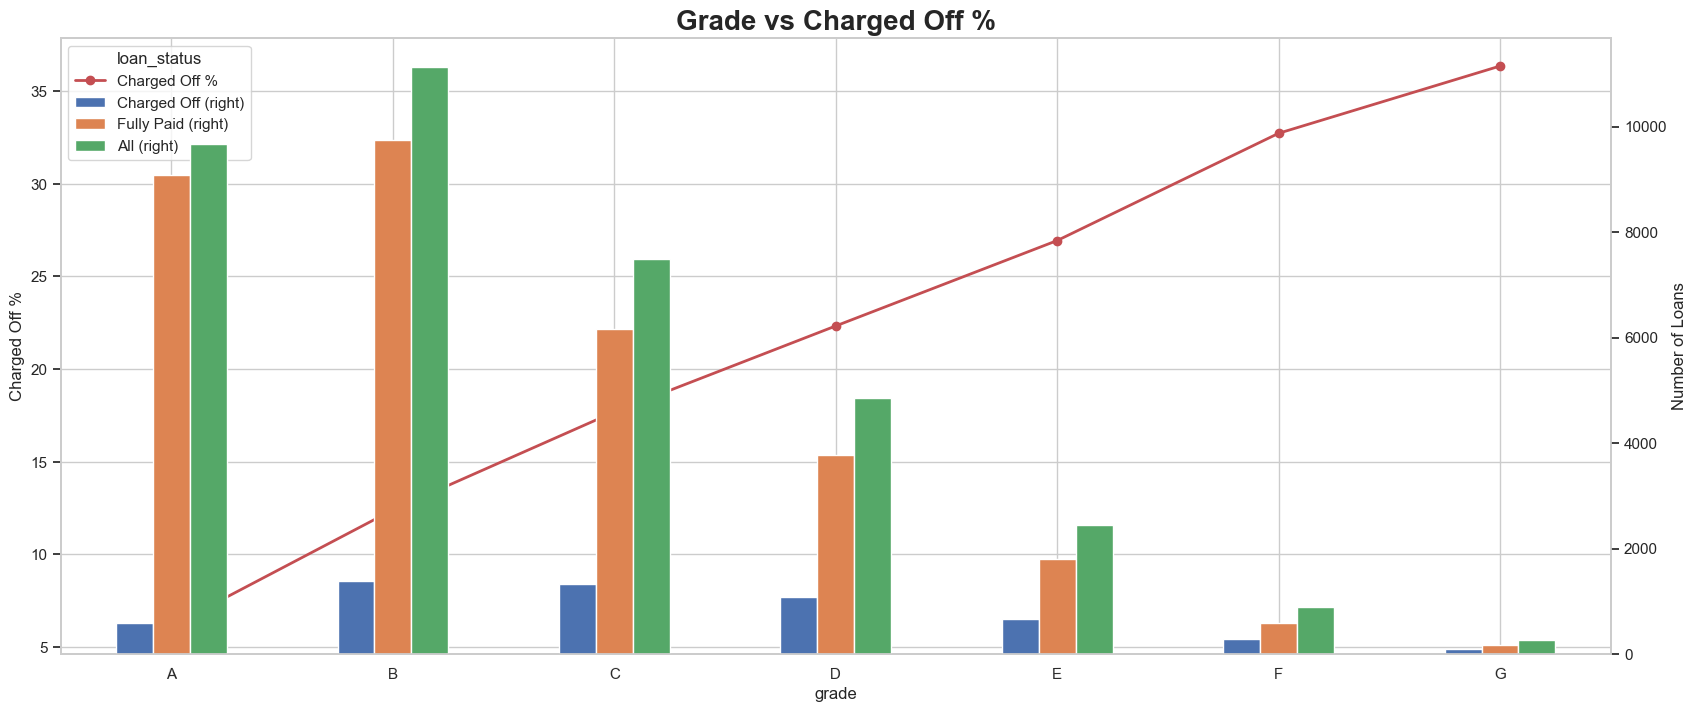

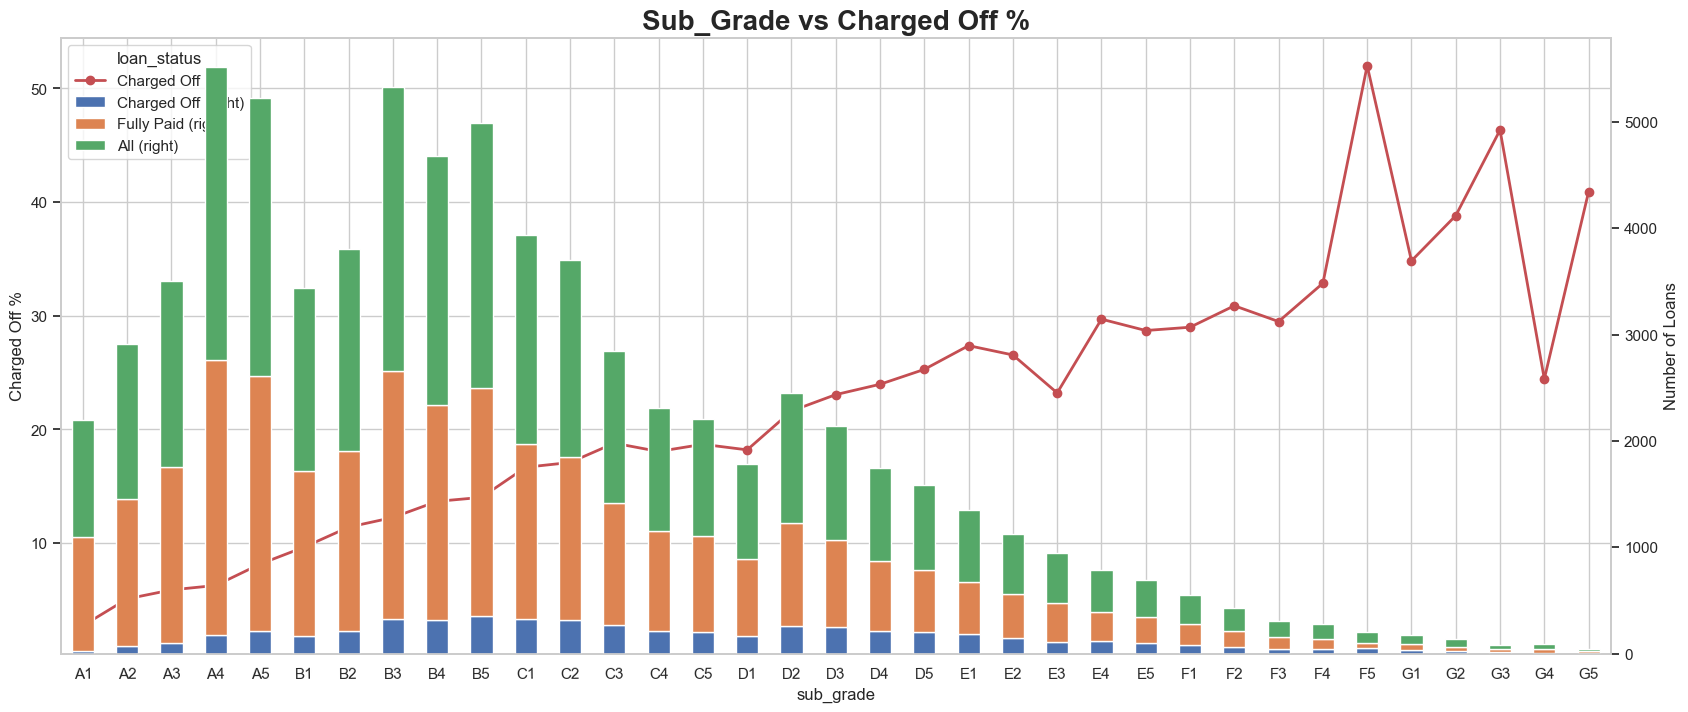

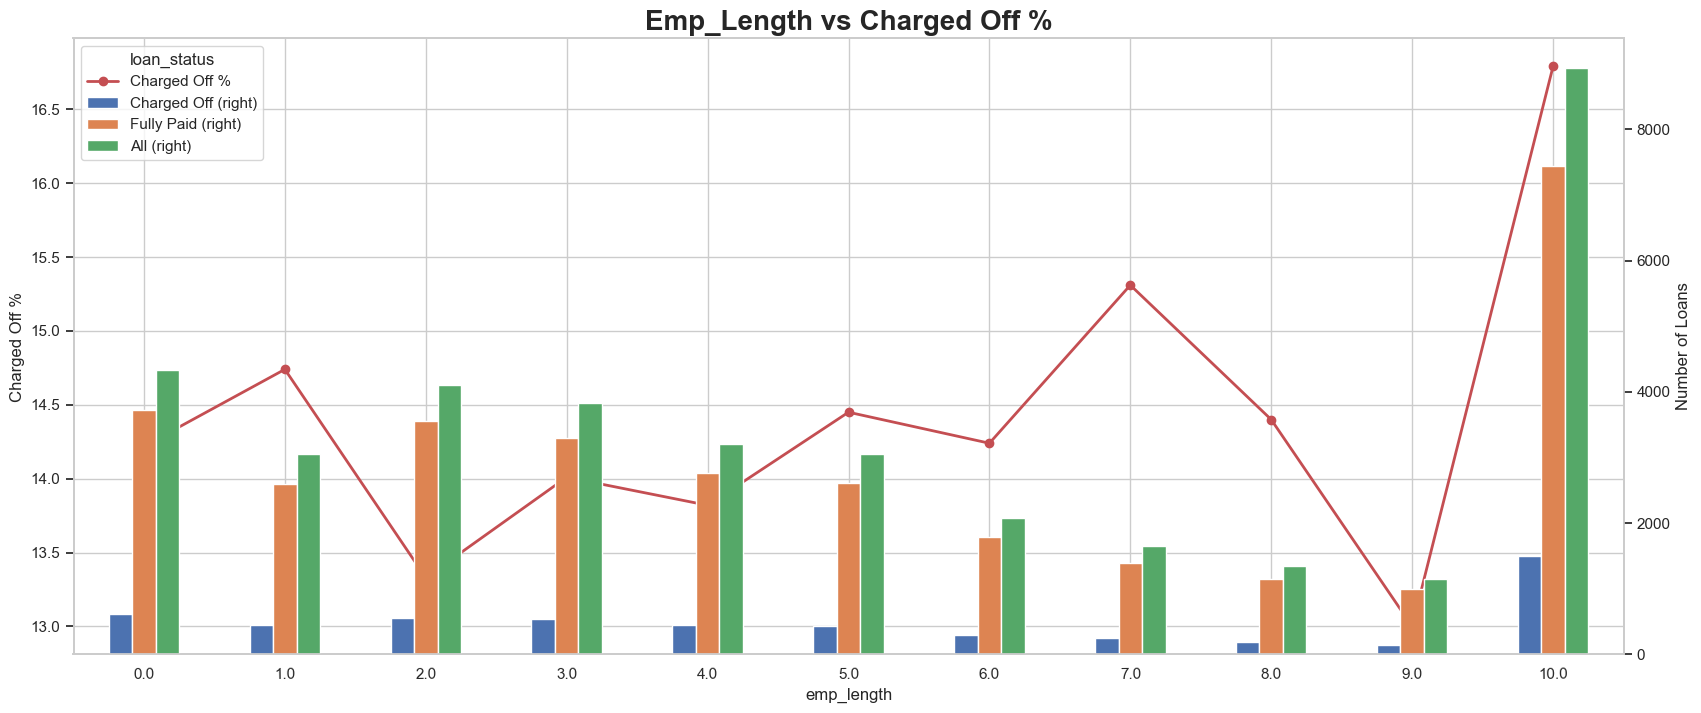

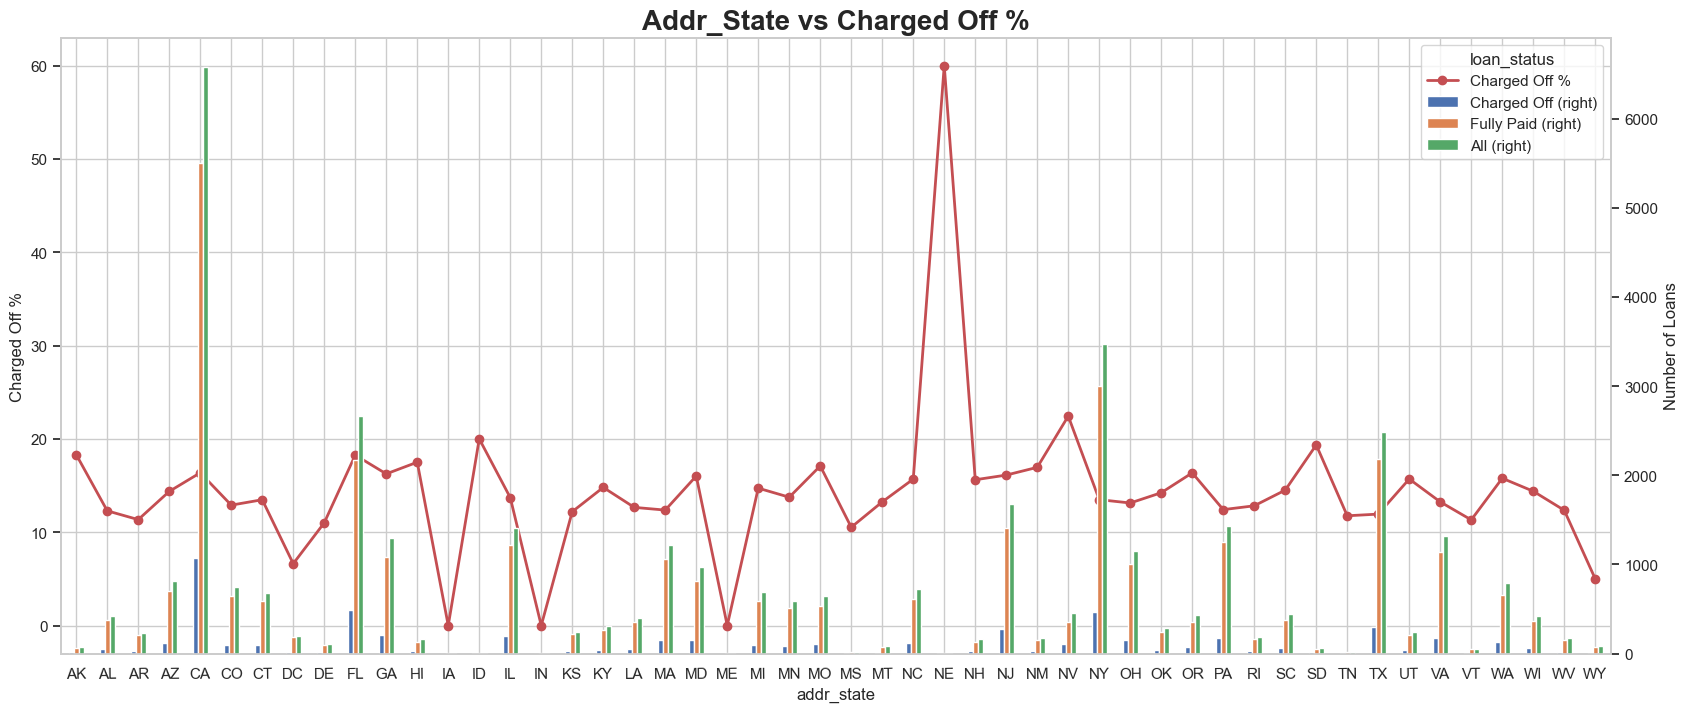

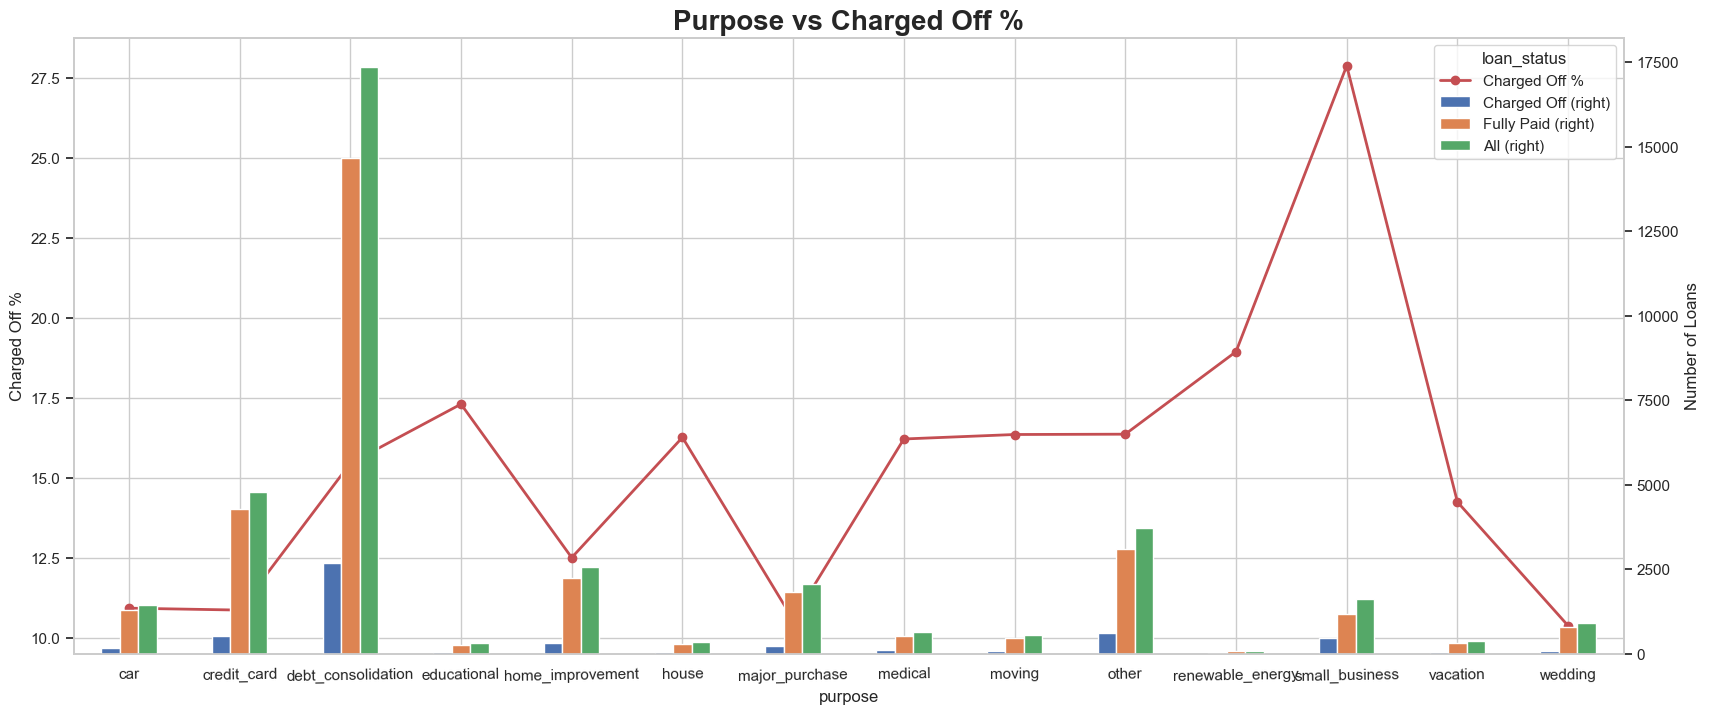

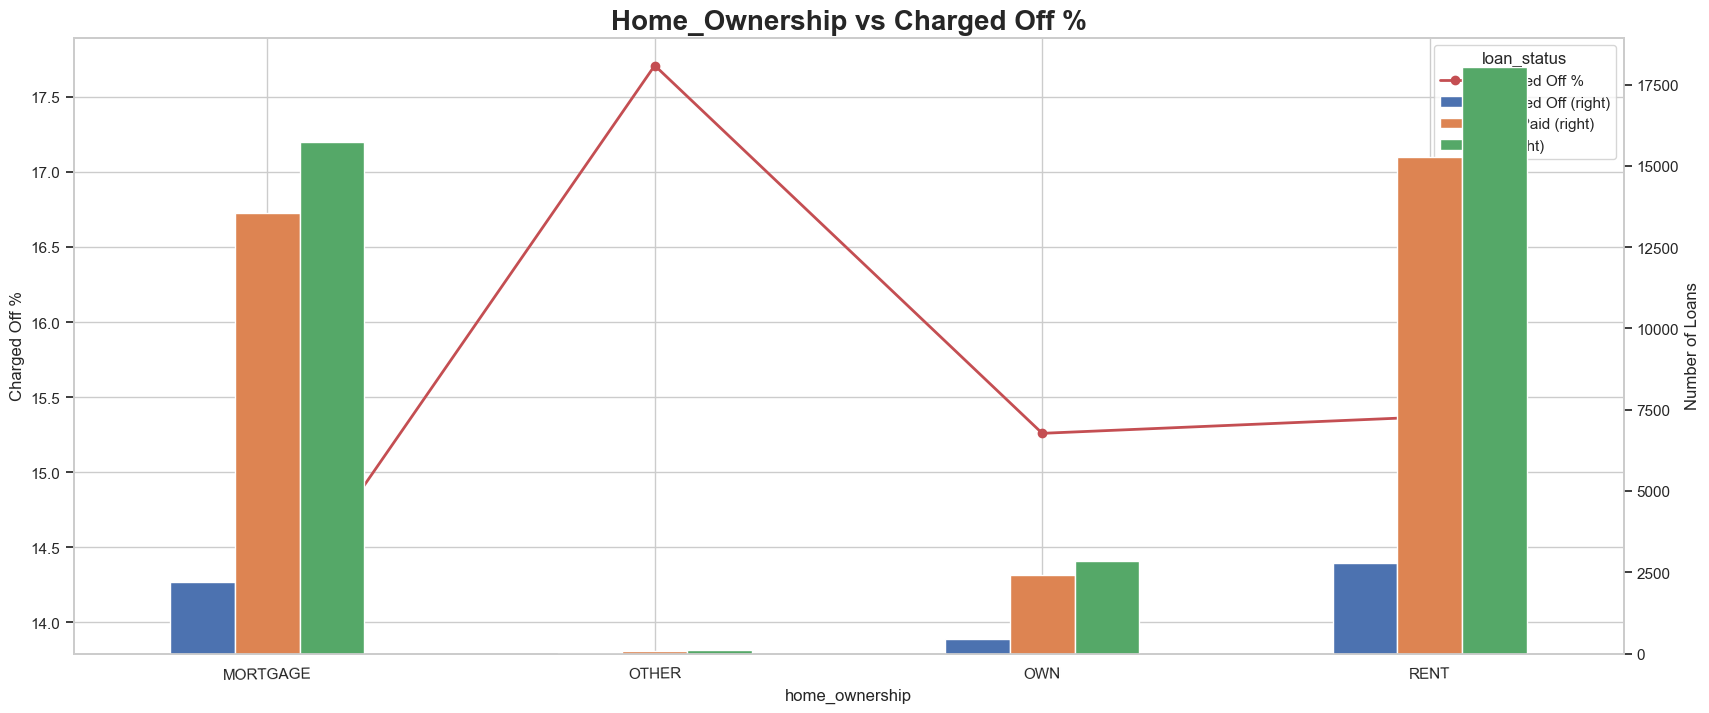

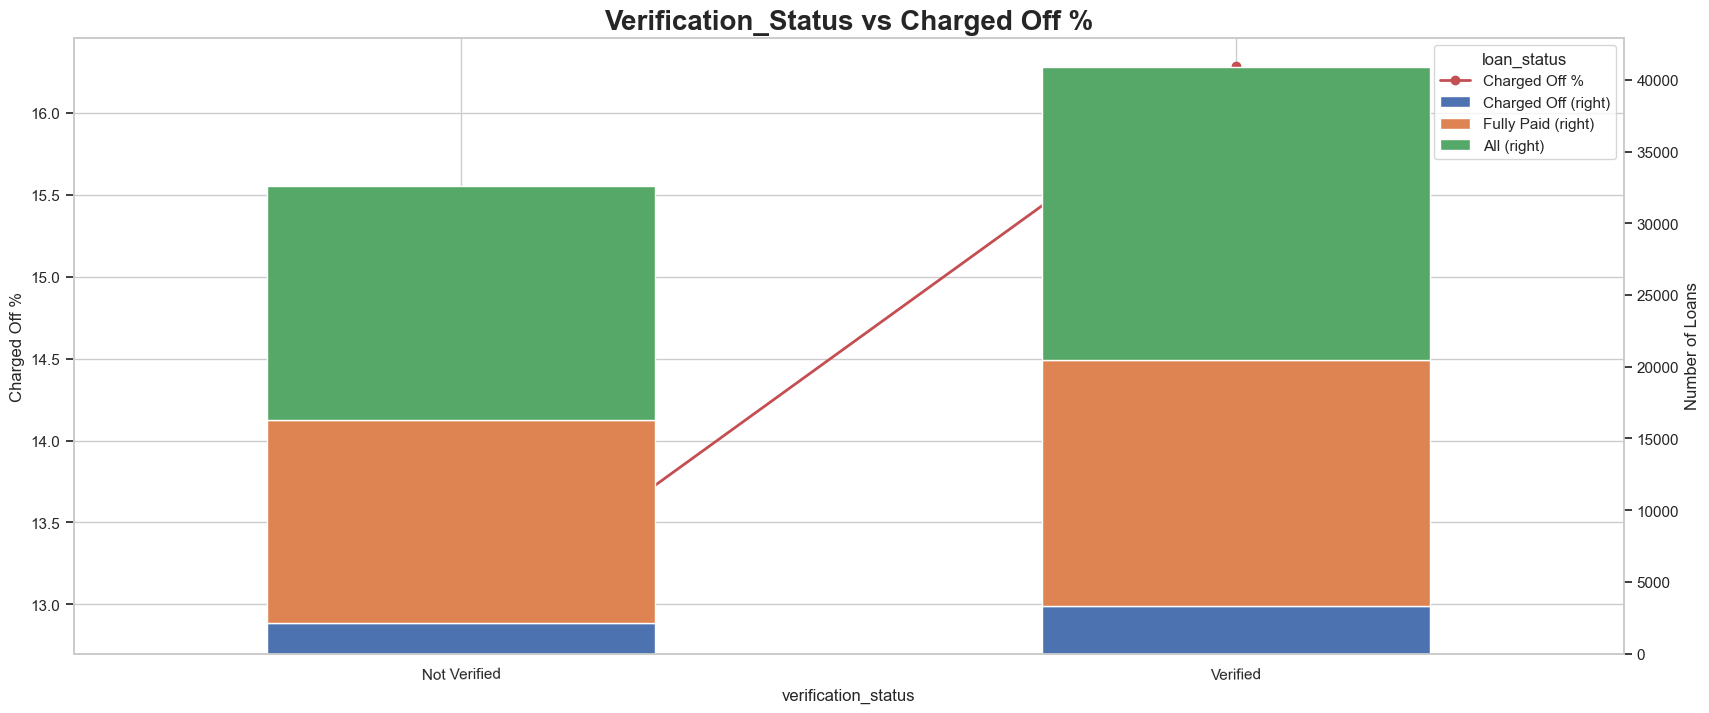

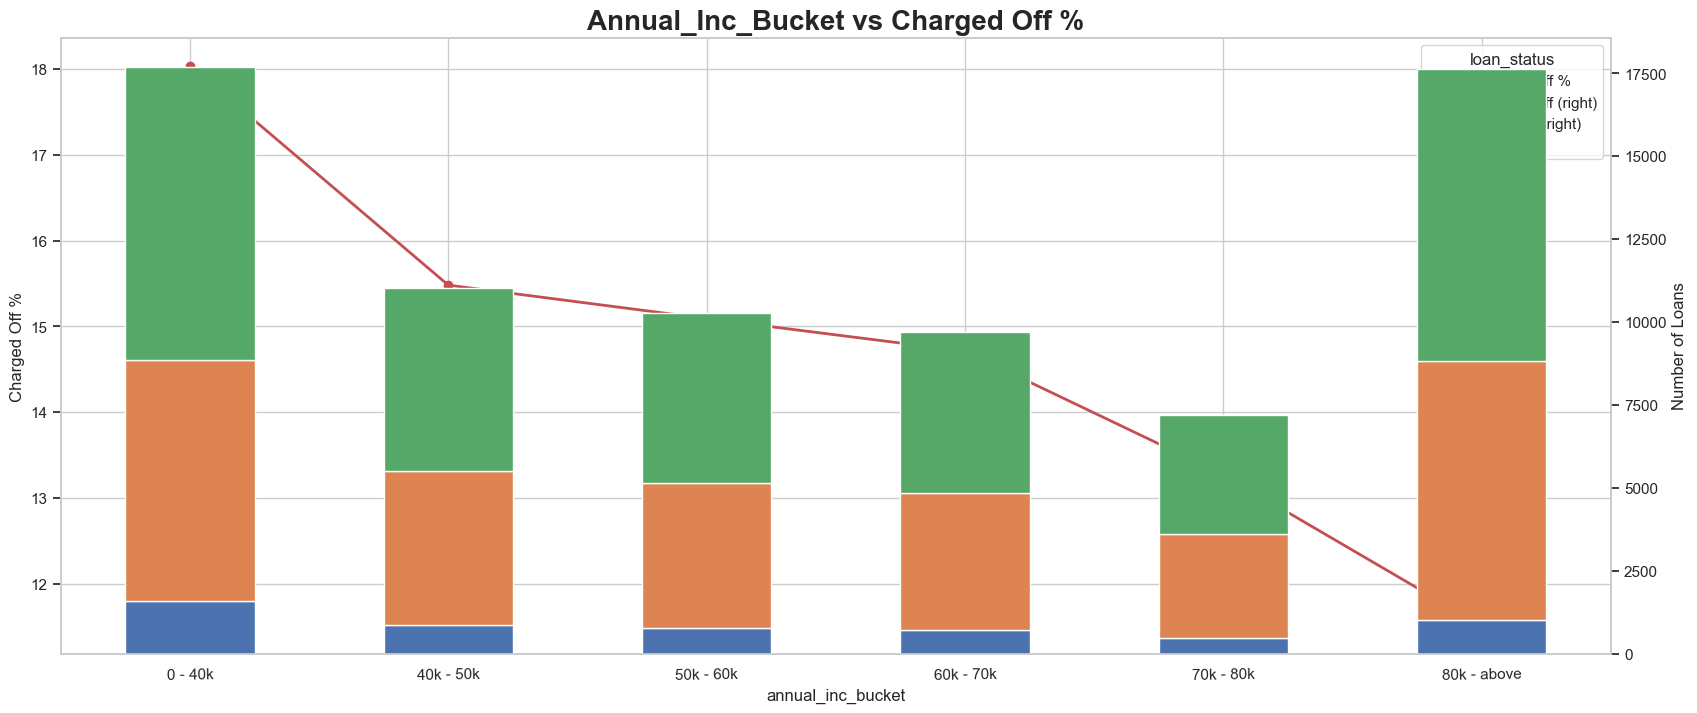

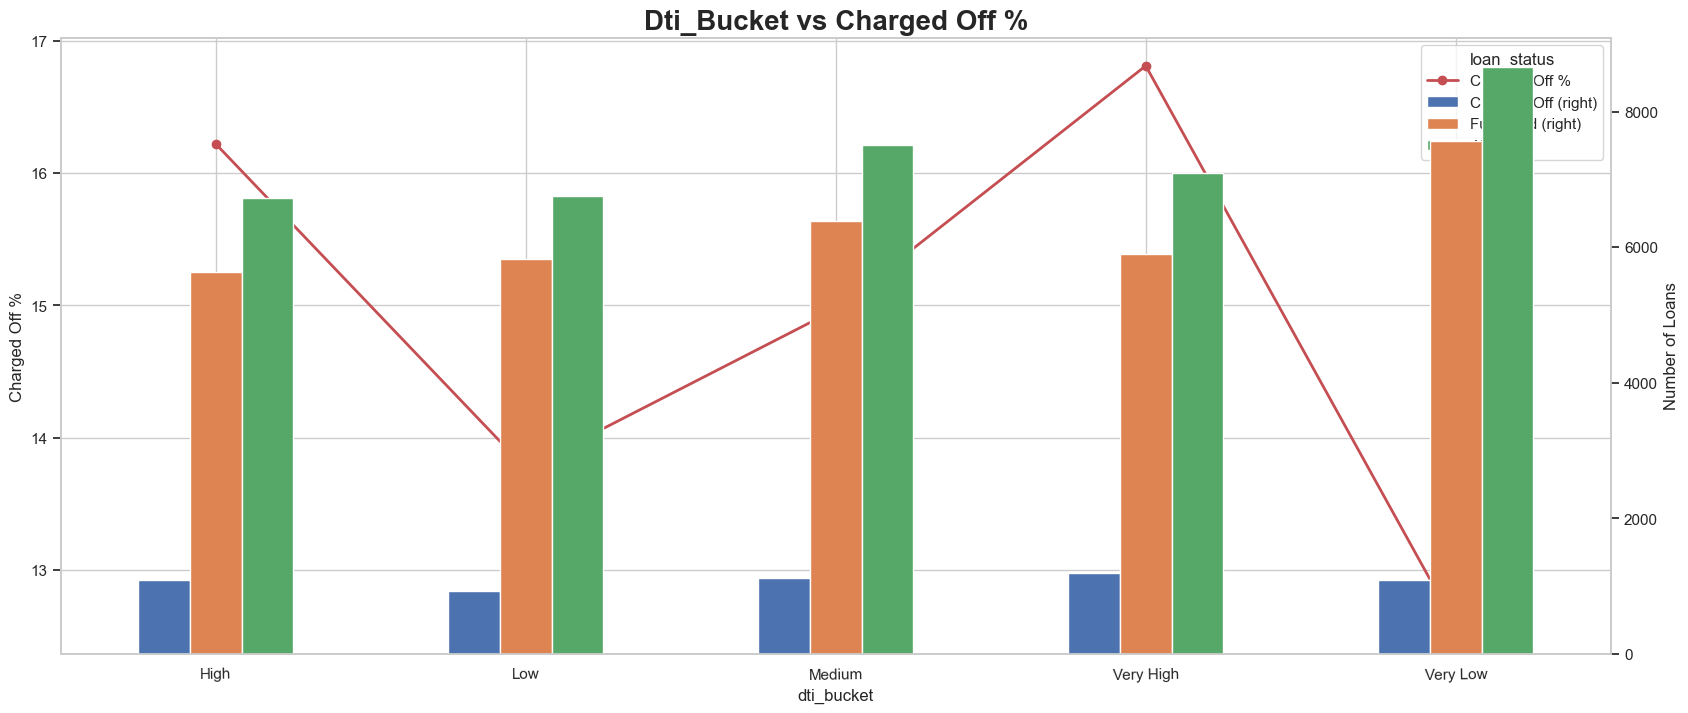

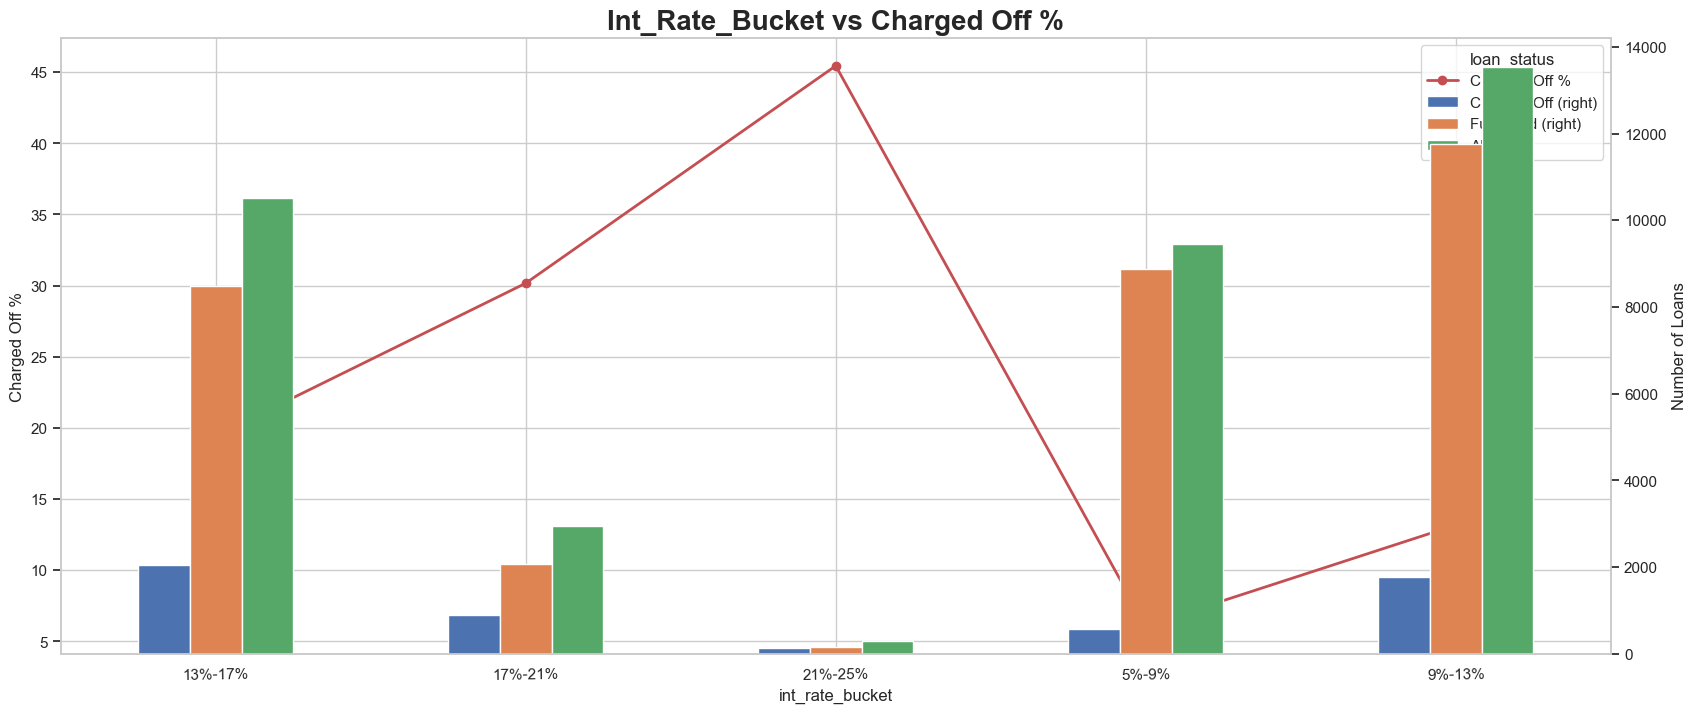

In [147]:
columns_config = {
    'grade': {},
    'sub_grade': {'stacked': True},
    'emp_length': {},
    'addr_state': {},
    'purpose': {},
    'home_ownership': {},
    'verification_status': {'stacked': True},
    'annual_inc_bucket': {'stacked': True},
    'dti_bucket': {},
    'int_rate_bucket': {}
}

for column, plot_config in columns_config.items():
    stacked = plot_config.get('stacked', False)
    plot_charged_off_percentage(df, column, stacked)

## Summary of Multivariate Analysis

- Loan applicants in Grades B, C, and D exhibit a higher likelihood of defaulting.
- Borrowers with subgrades B3, B4, and B5 demonstrate the highest tendency to default.
- Applicants with 10 years of experience are most prone to defaulting.
- Borrowers residing in California (CA), Florida (FL), and New Jersey (NJ) show the highest default tendency.
- Renters have the highest tendency to default on loans.
- Default tendencies are highest among borrowers in lower income brackets, which generally decrease with higher annual incomes.
- The likelihood of defaulting on loans increases with higher interest rates.